In [1]:
import sys
sys.path.append('../src/')

# Import and Format Data

In [2]:
from pandas import read_csv, to_datetime, concat
from numpy import where

holidays_data = read_csv('../data/holiday_17_18_19.csv - holiday_17_18_19.csv')
holidays = list(to_datetime(holidays_data["Date"], format='%d.%m.%Y'))
meteo_data = read_csv('../data/IST_meteo_data_2017_2018_2019.csv - IST_meteo_data_2017_2018_2019.csv')
building_data_2017 = read_csv('../data/IST_South_Tower_2017_Ene_Cons.csv')
building_data_2018 = read_csv('../data/IST_South_Tower_2018_Ene_Cons.csv')

# set index
meteo_data['yyyy-mm-dd hh:mm:ss'] = to_datetime(meteo_data['yyyy-mm-dd hh:mm:ss'], format='%Y-%m-%d %H:%M:%S')
meteo_data = meteo_data.set_index('yyyy-mm-dd hh:mm:ss')
building_data_2017['Date_start'] = to_datetime(building_data_2017['Date_start'], format='%d-%m-%Y %H:%M')
building_data_2018['Date_start'] = to_datetime(building_data_2018['Date_start'], format='%d-%m-%Y %H:%M')
building_data_2017 = building_data_2017.set_index('Date_start')
building_data_2018 = building_data_2018.set_index('Date_start')
building_data = concat([building_data_2017, building_data_2018])

# resample data and combine into one dataframe
meteo_data_resample = meteo_data.resample('H', closed='right', label='right')[
    'temp_C', 'HR', 'windSpeed_m/s', 'windGust_m/s', 'pres_mbar',
    'solarRad_W/m2', 'rain_mm/h'].mean()
meteo_data_resample["rain_day"] = meteo_data.resample('H', closed='right', label='right')['rain_day'].max()
df = building_data.join(meteo_data_resample)
df['holiday'] = where(df.index.to_period('D').astype('datetime64[ns]').isin(holidays), 1, 0)

# Data Analysis

## First look at Timeseries

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Power_kW    temp_C         HR  windSpeed_m/s  \
2017-01-01 00:00:00  100.810001  8.720000  74.600000       2.138000   
2017-01-01 01:00:00   99.054135  8.490000  75.000000       2.335833   
2017-01-01 02:00:00   98.539567  7.877500  76.658333       2.776250   
2017-01-01 03:00:00  101.435784  7.212417  80.441667       3.384083   
2017-01-01 04:00:00   98.481664  6.817083  81.300000       3.490667   

                     windGust_m/s    pres_mbar  solarRad_W/m2  rain_mm/h  \
2017-01-01 00:00:00      3.774000  1029.000000       1.163000        0.0   
2017-01-01 01:00:00      3.228833  1029.000000       1.371250        0.0   
2017-01-01 02:00:00      3.501250  1028.083333       1.581250        0.0   
2017-01-01 03:00:00      4.193000  1028.000000       1.318083        0.0   
2017-01-01 04:00:00      4.360667  1028.000000       1.569750        0.0   

                     rain_day  holiday  
2017-01-01 00:00:00       0.0        1  
2017-01-01 01:00:00       0.0        1  
2017-01-01 02:00:00       0.0        1  
2017-01-01 03:00:00       0.0        1  
2017-01-01 04:00:00       0.0        1

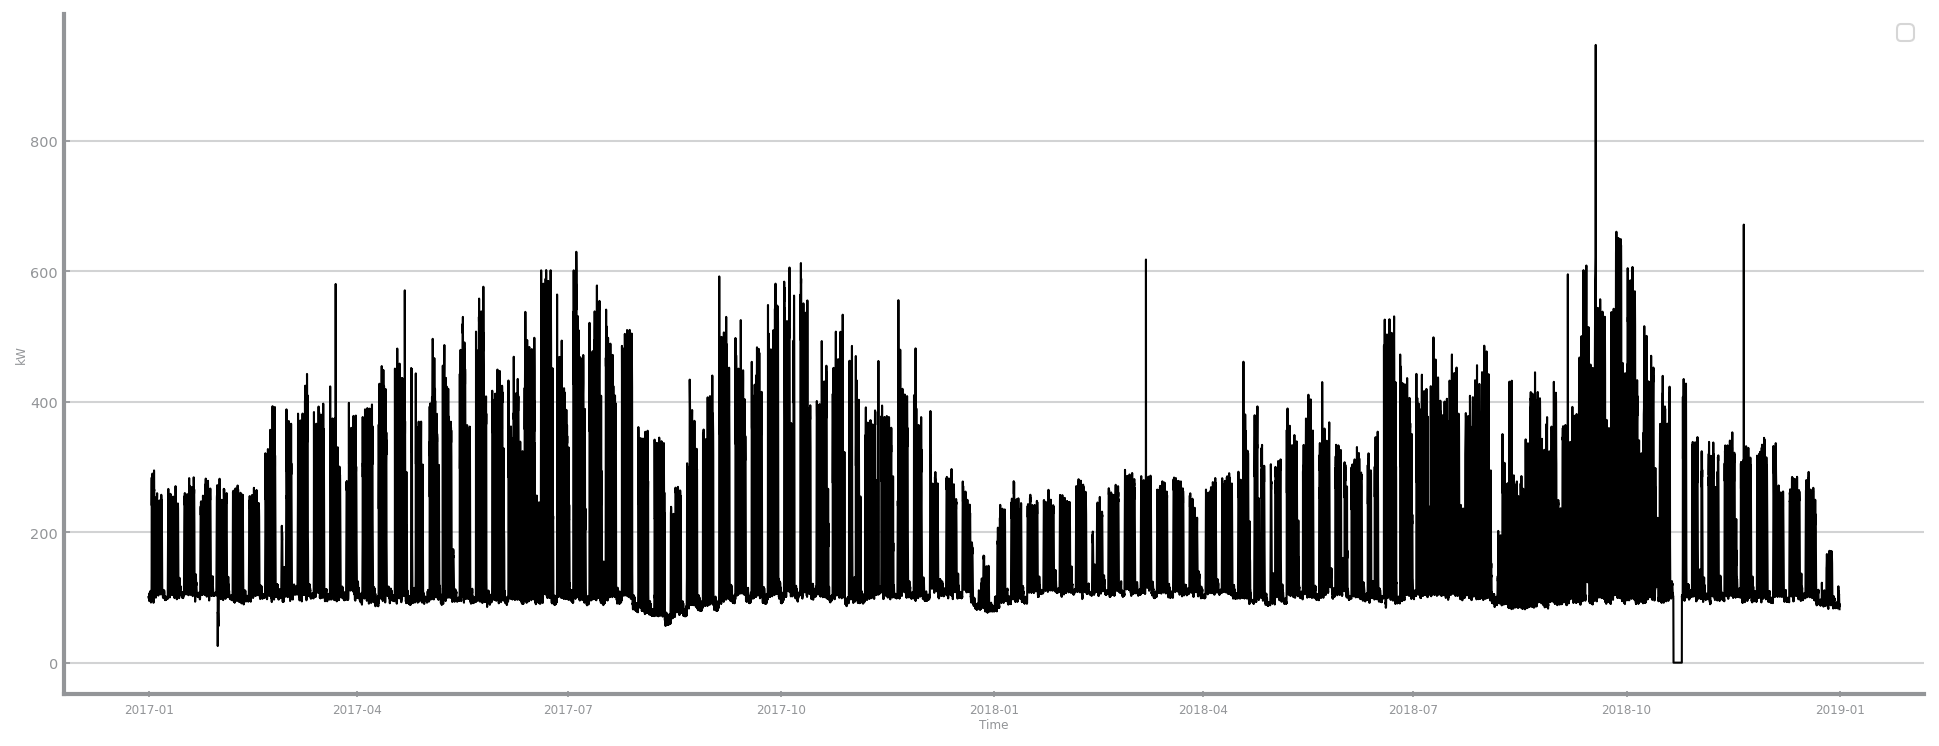

In [3]:
from ds_tools.profiling import plot_timeseries

plot_timeseries(df, columns=['Power_kW'], y_labels=['kW'])
df.head()


## Missing Values

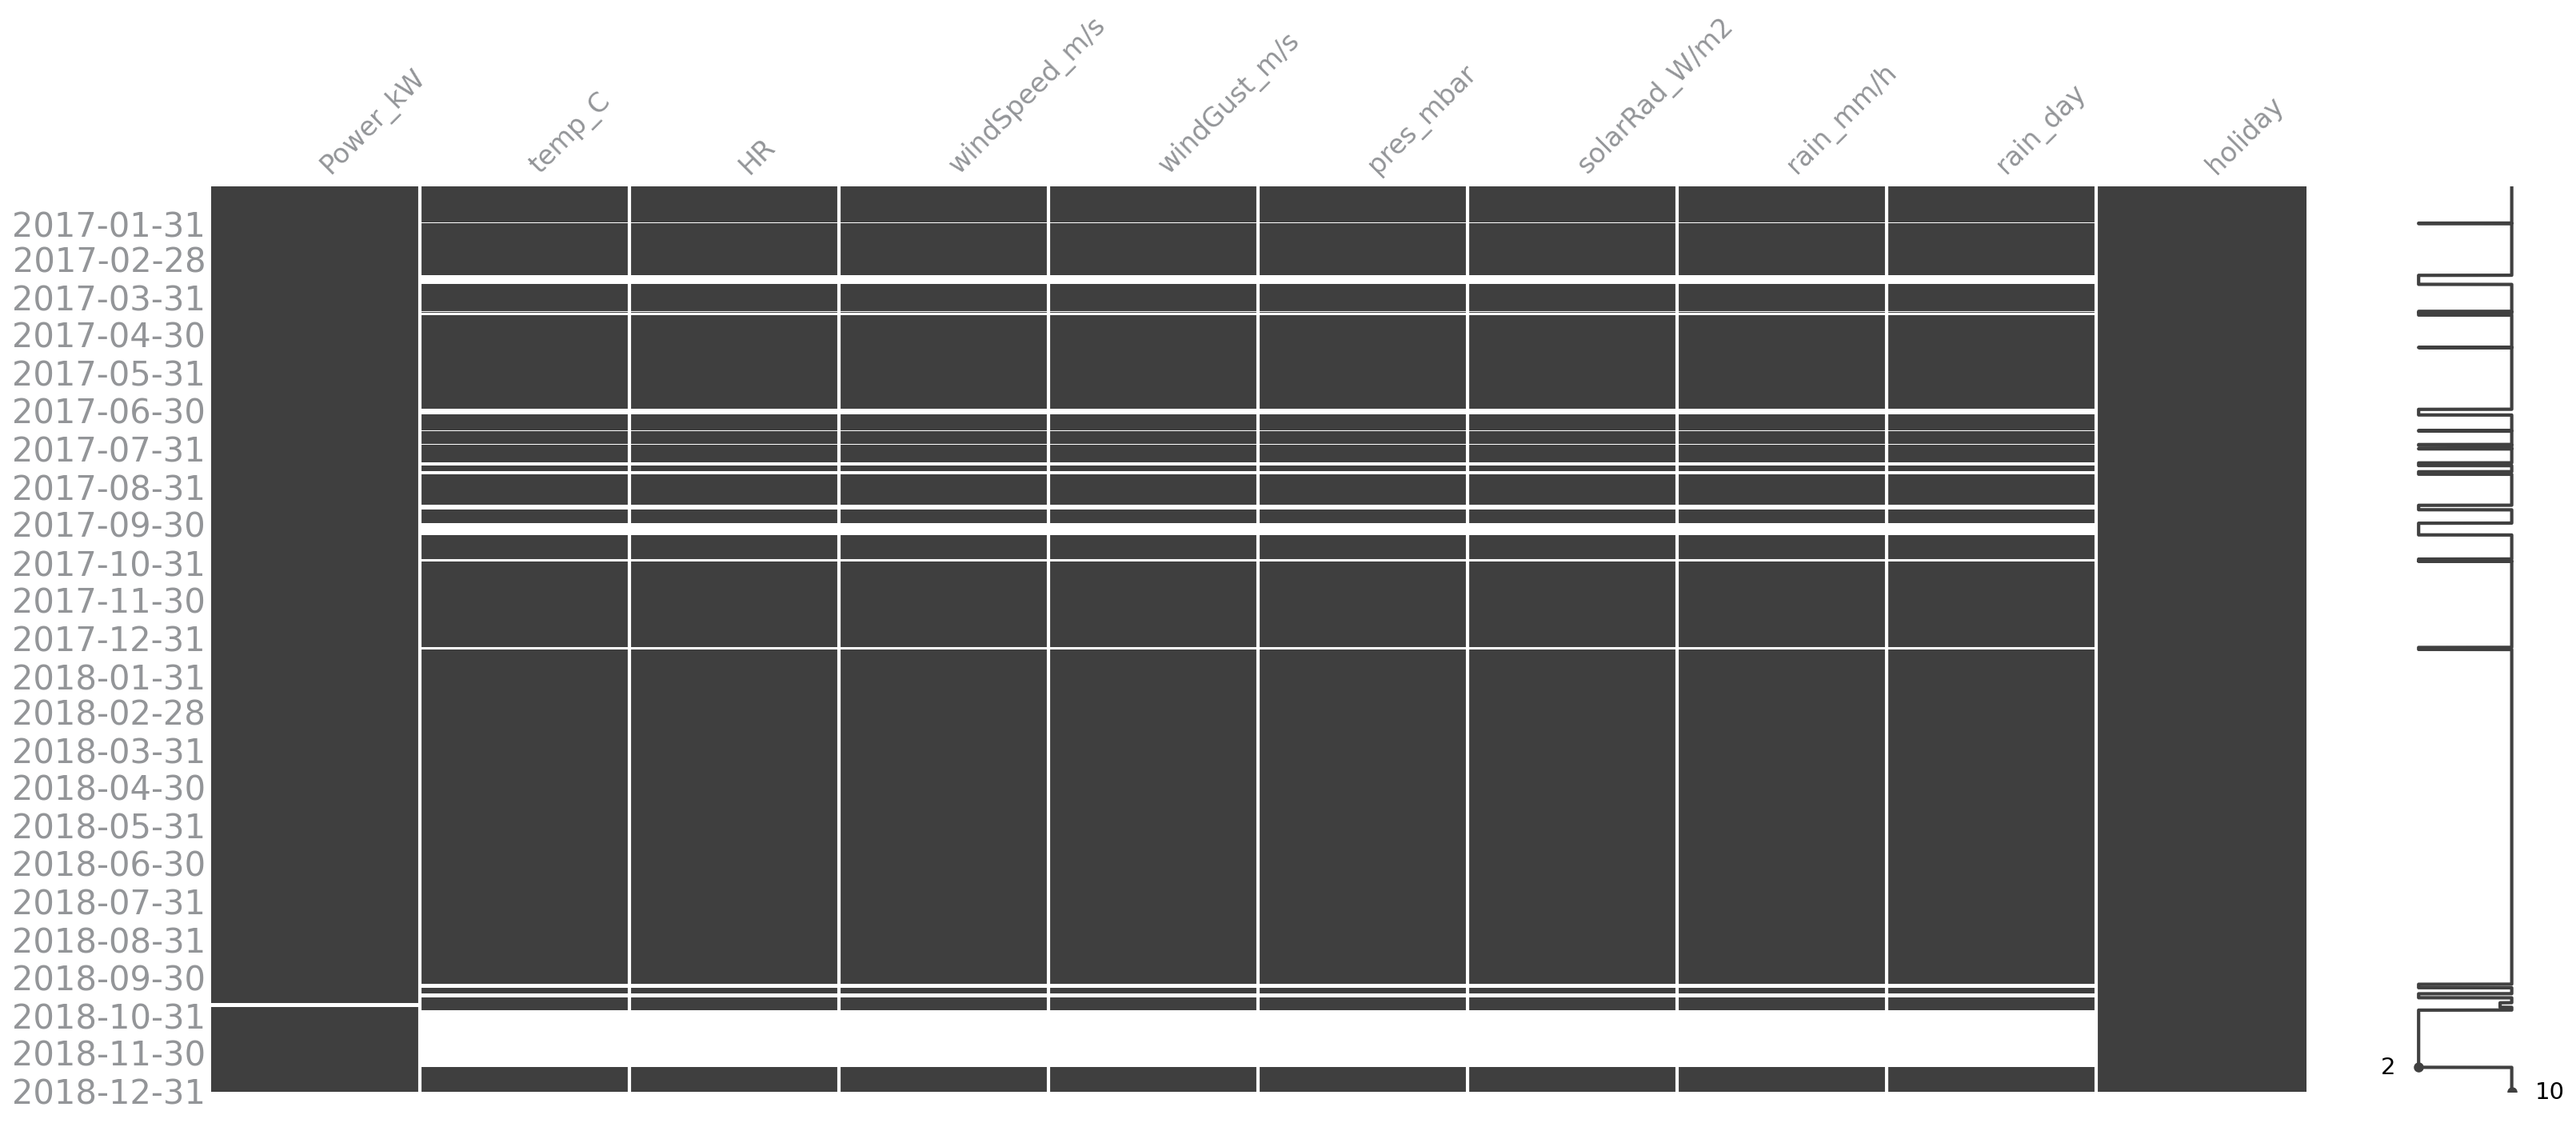

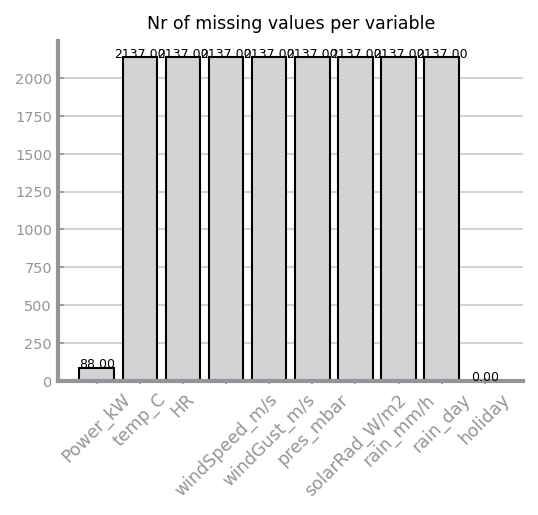

In [4]:
from missingno import matrix
from ds_tools.profiling import show_missing_values
from numpy import nan

df['Power_kW'].replace(0, nan, inplace=True)
matrix(df, freq='M')
show_missing_values(df)

## Fill Missing Values

To keep it simple, all missing values are imputed by 0.

In [5]:
df = df.fillna(0)

## Histogram and Correclation of Variables

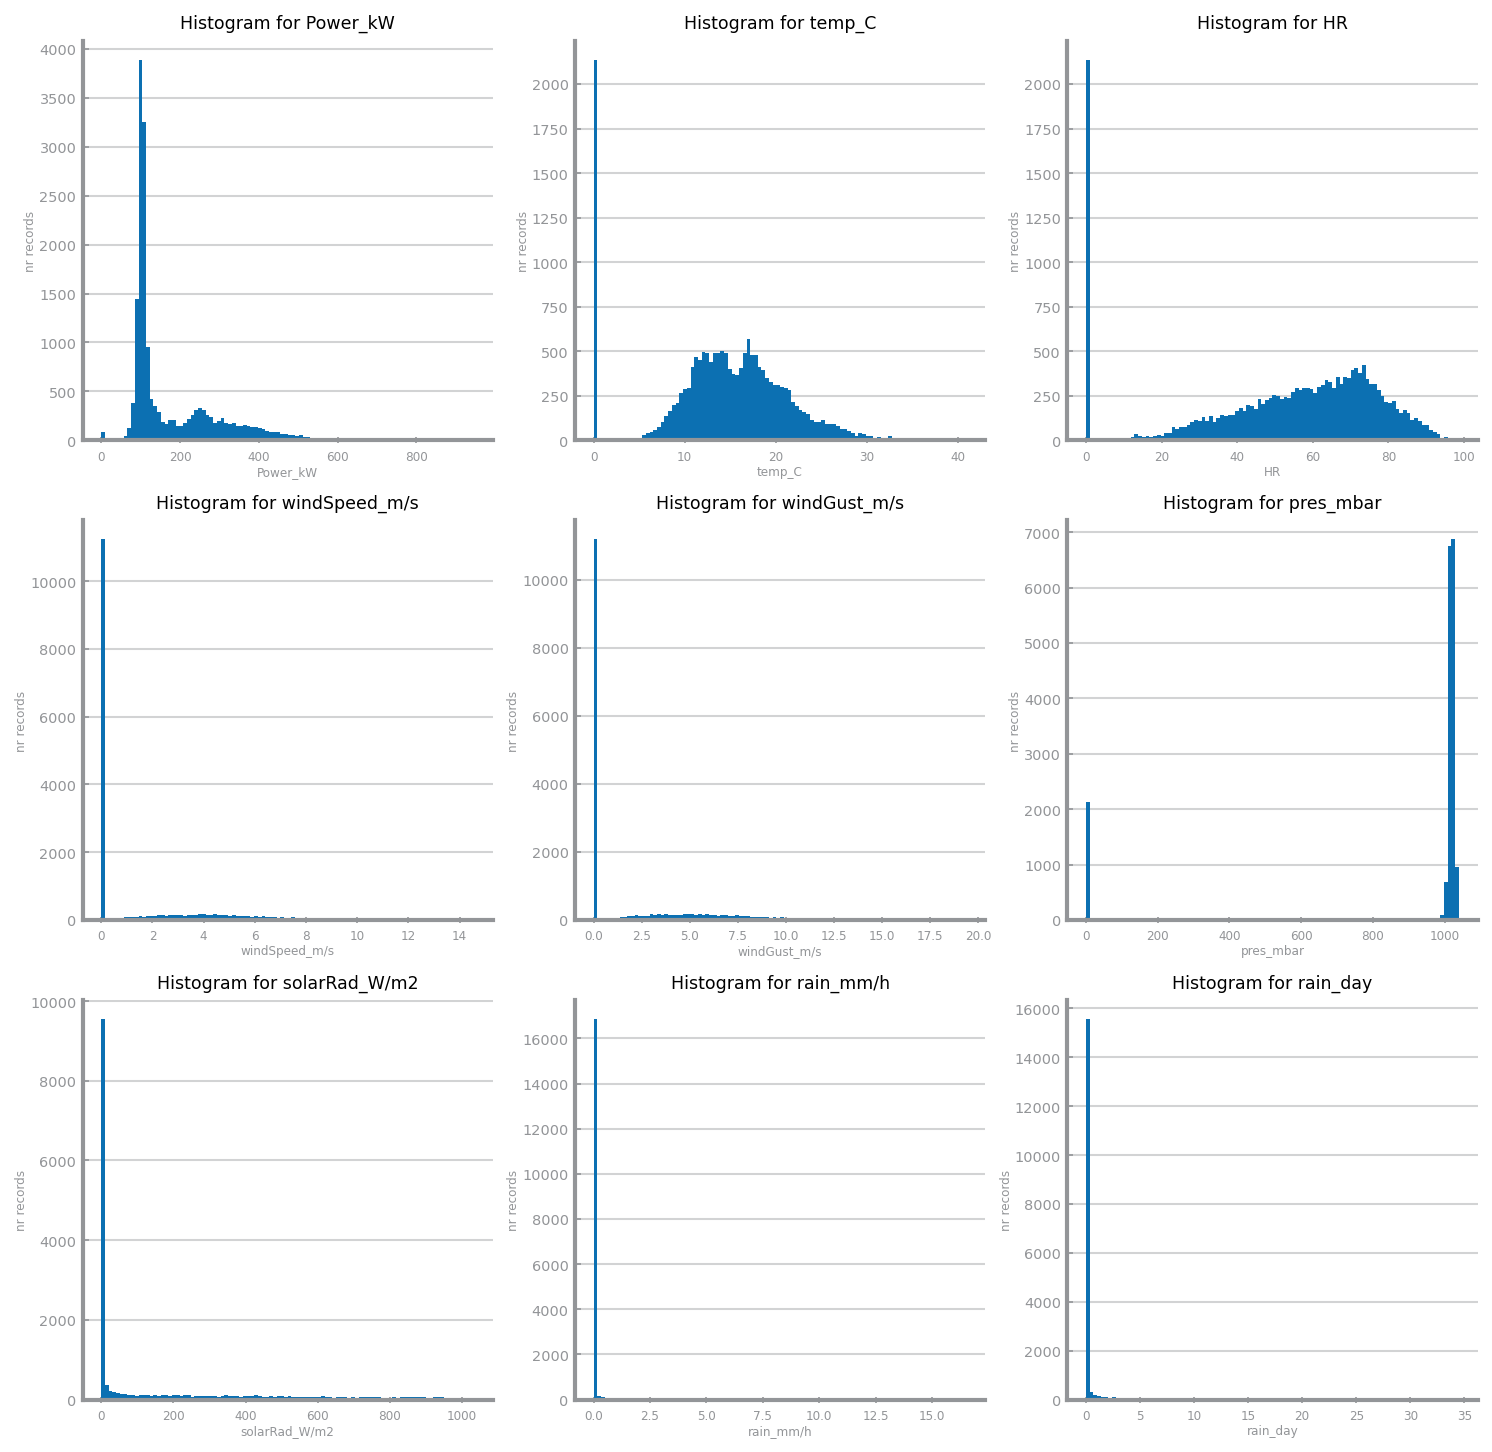

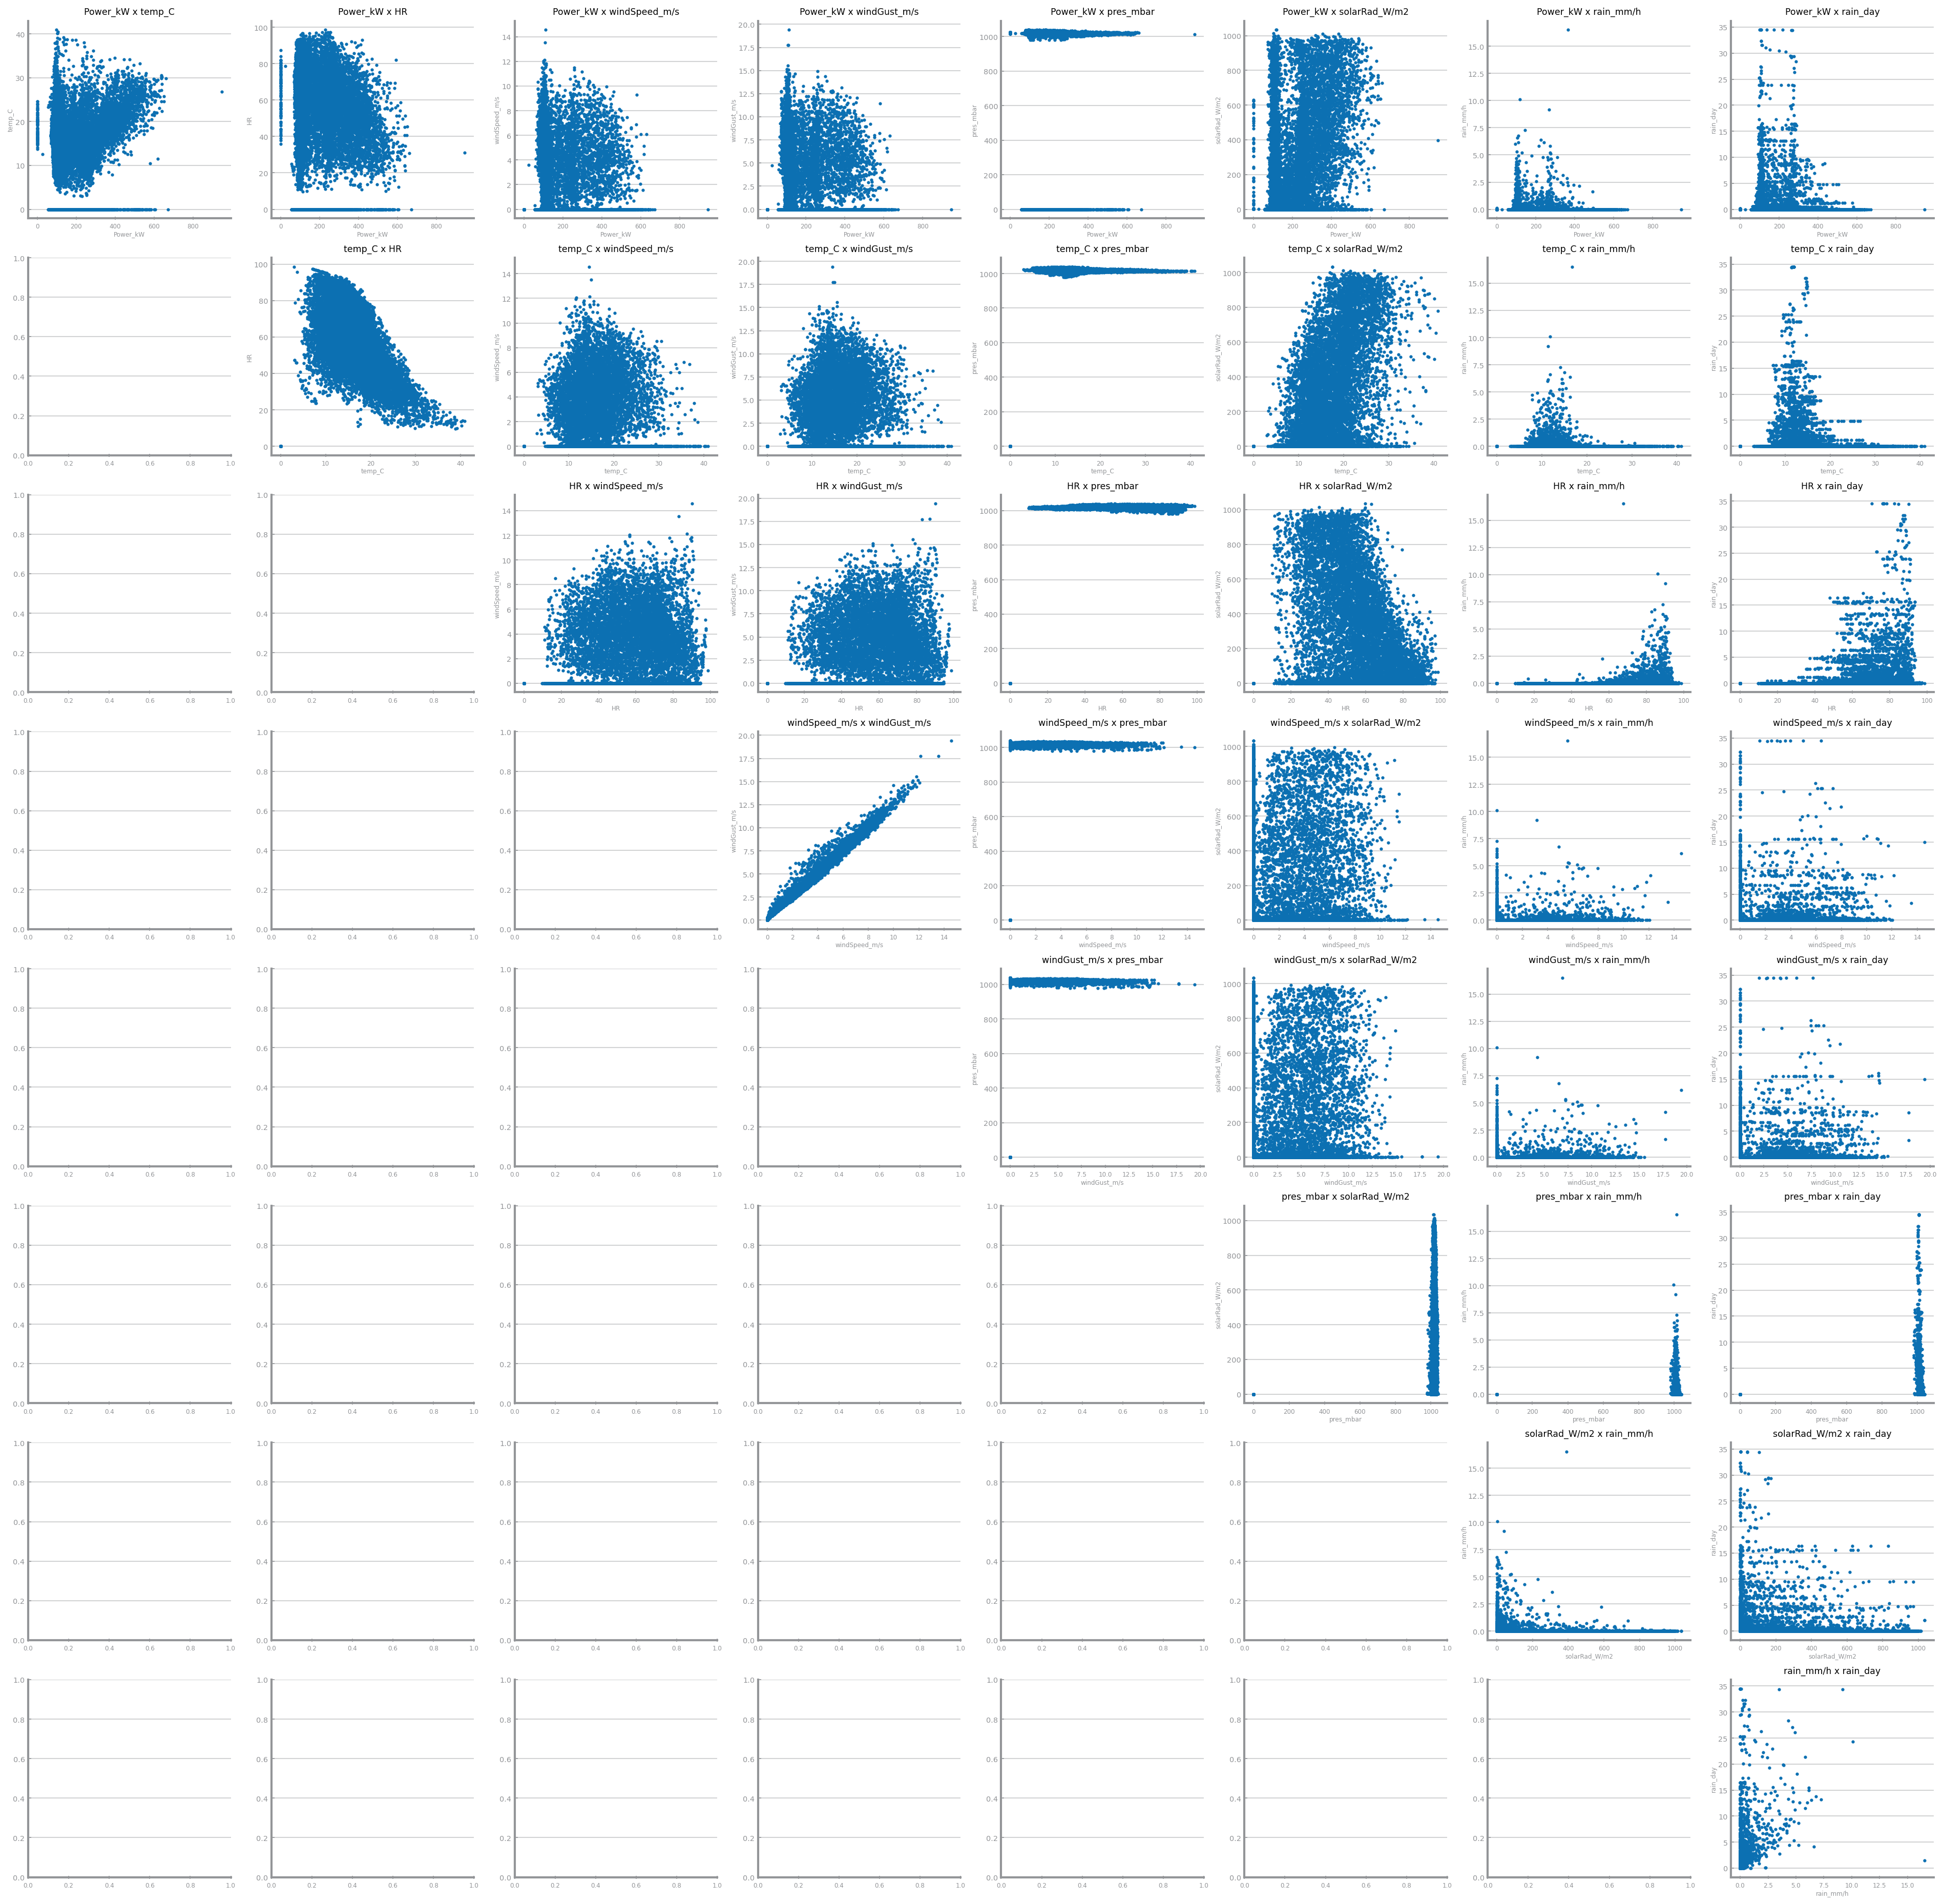

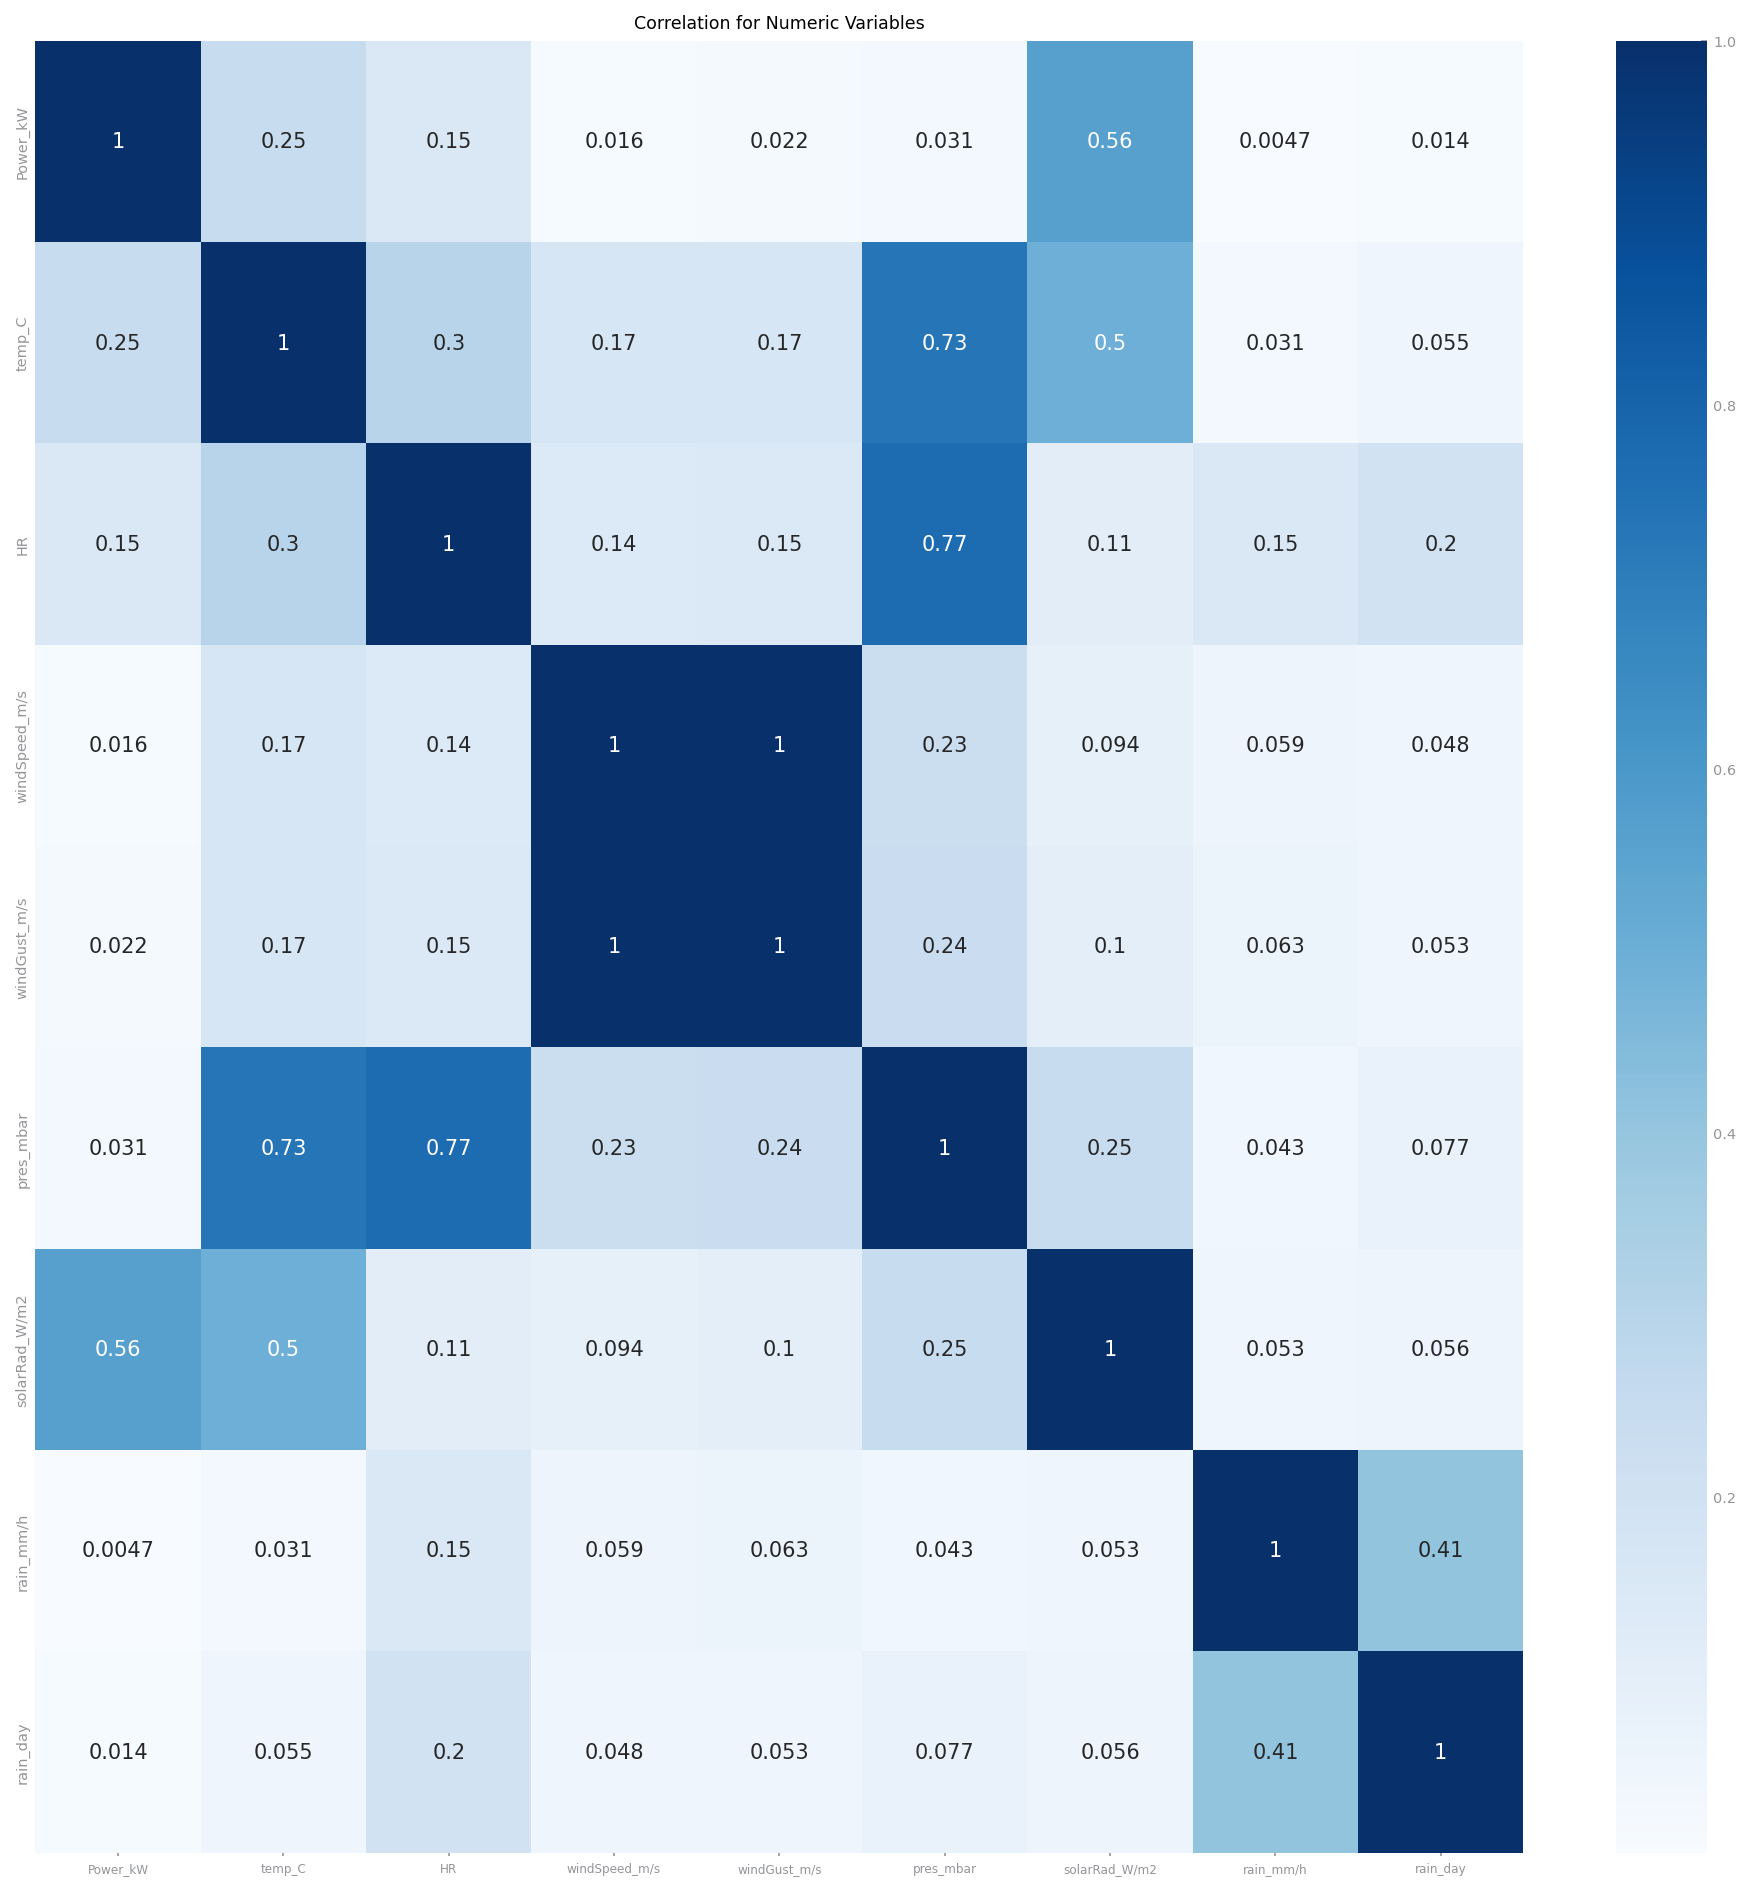

In [6]:
from ds_tools.profiling import show_histograms_numeric, show_sparsity, show_heatmap

show_histograms_numeric(df)
show_sparsity(df)
show_heatmap(df)

## Closer Look at Correlations

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


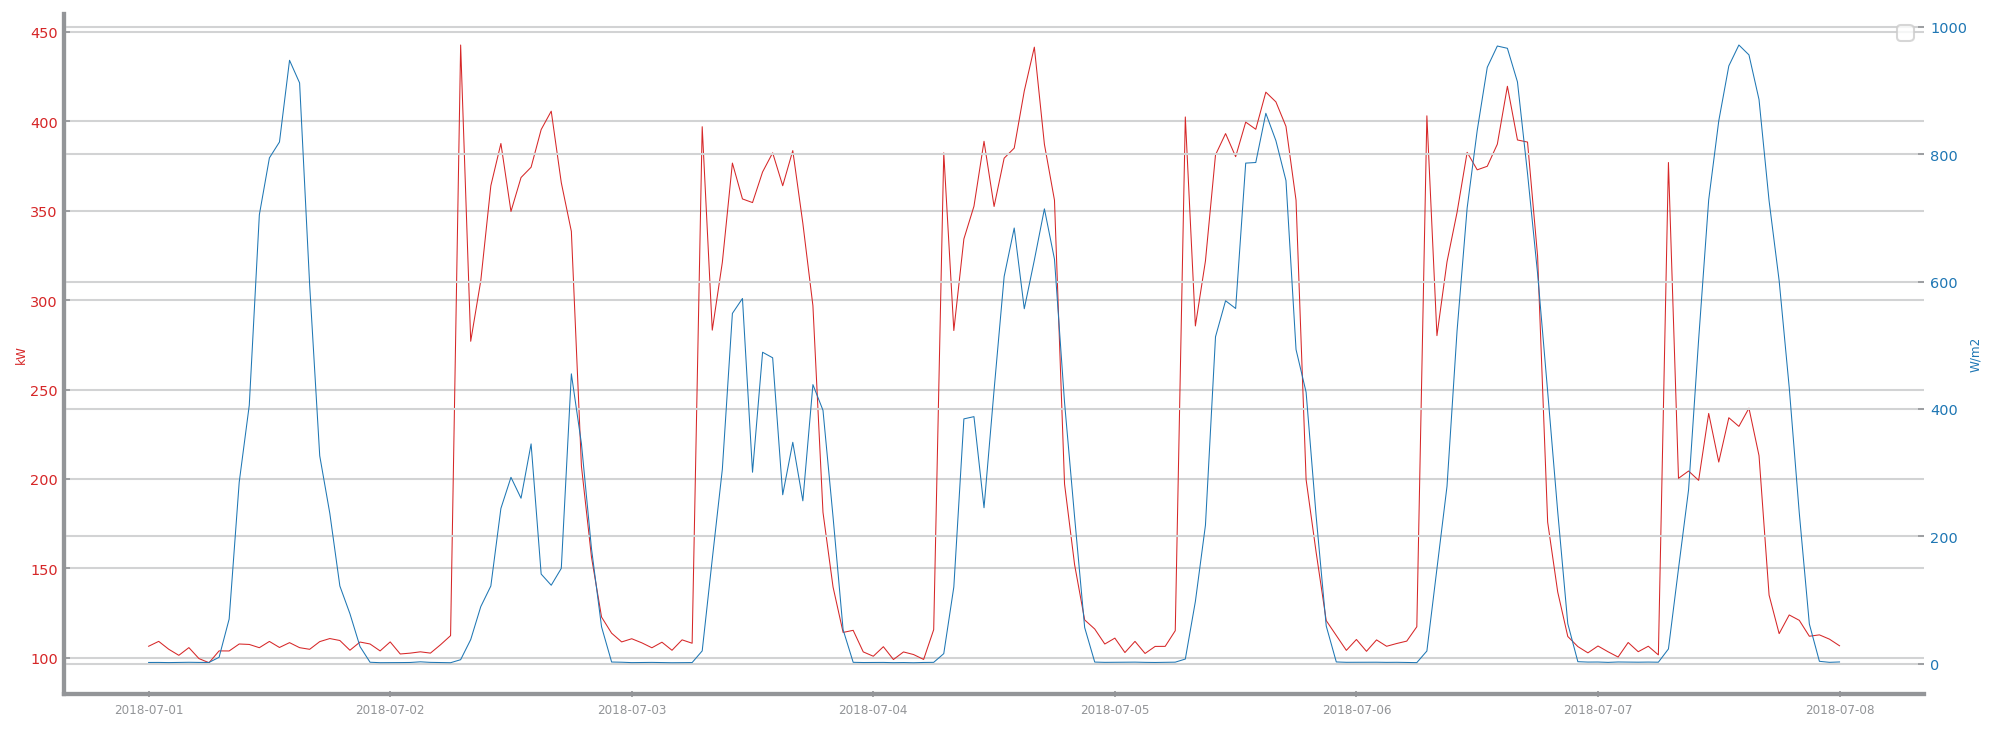

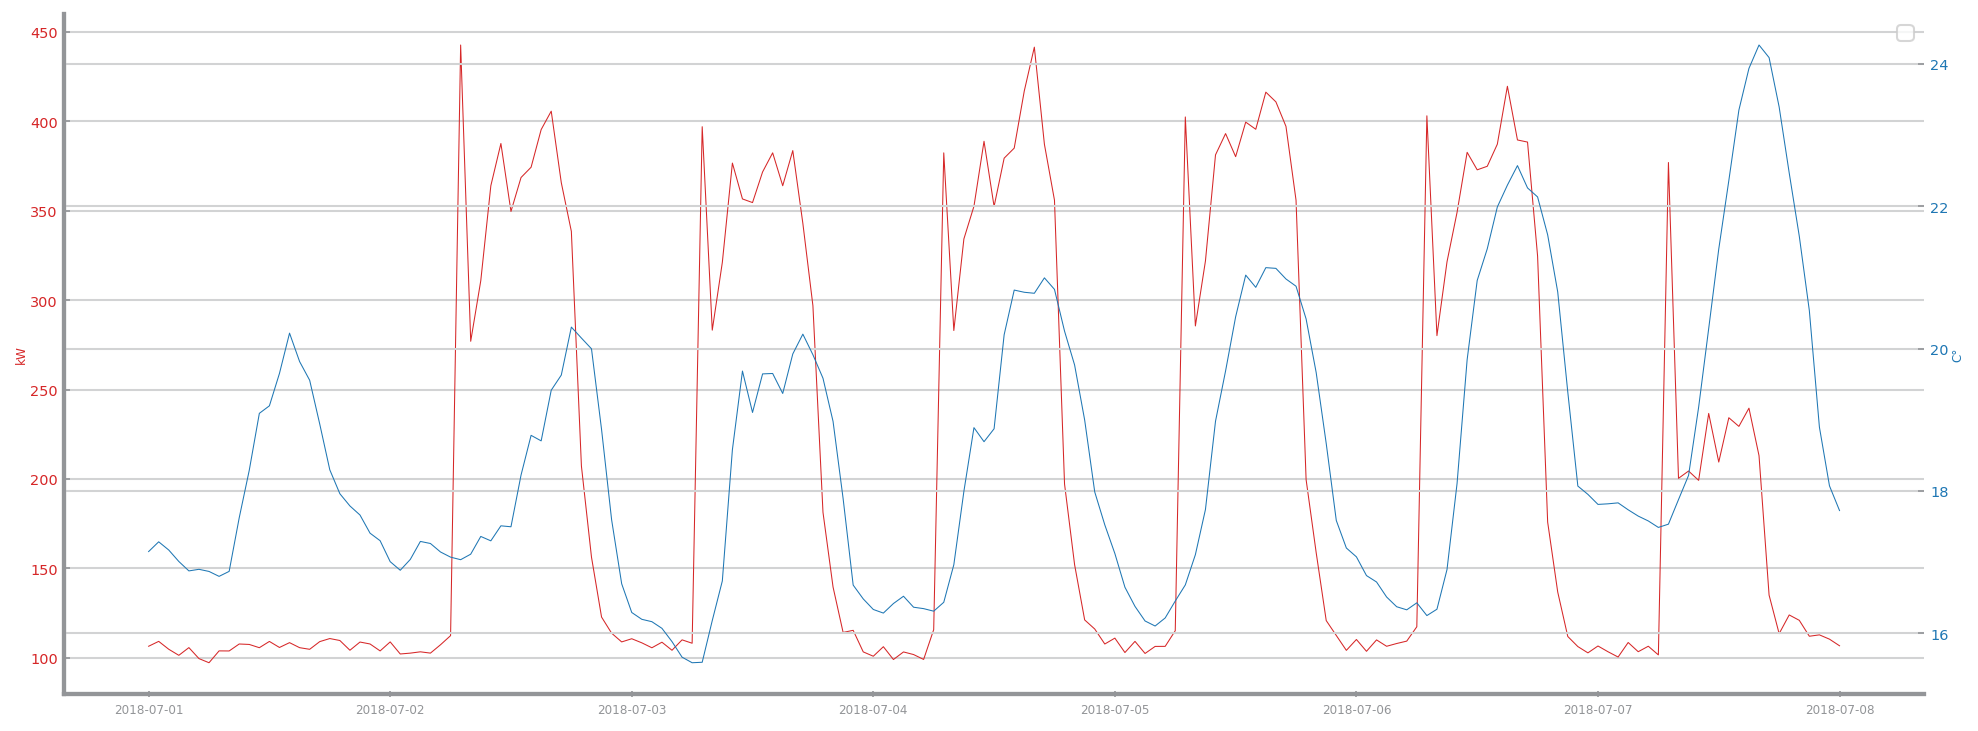

In [7]:
from datetime import datetime

start = datetime(year=2018, month=7, day=1)
end = datetime(year=2018, month=7, day=8)
plot_timeseries(df, columns=['Power_kW', 'solarRad_W/m2'], y_labels=['kW', 'W/m2'], start=start, end=end)
plot_timeseries(df, columns=['Power_kW', 'temp_C'], y_labels=['kW', 'C°'], start=start, end=end)

## Decompostion of Seasonalilty and Trends

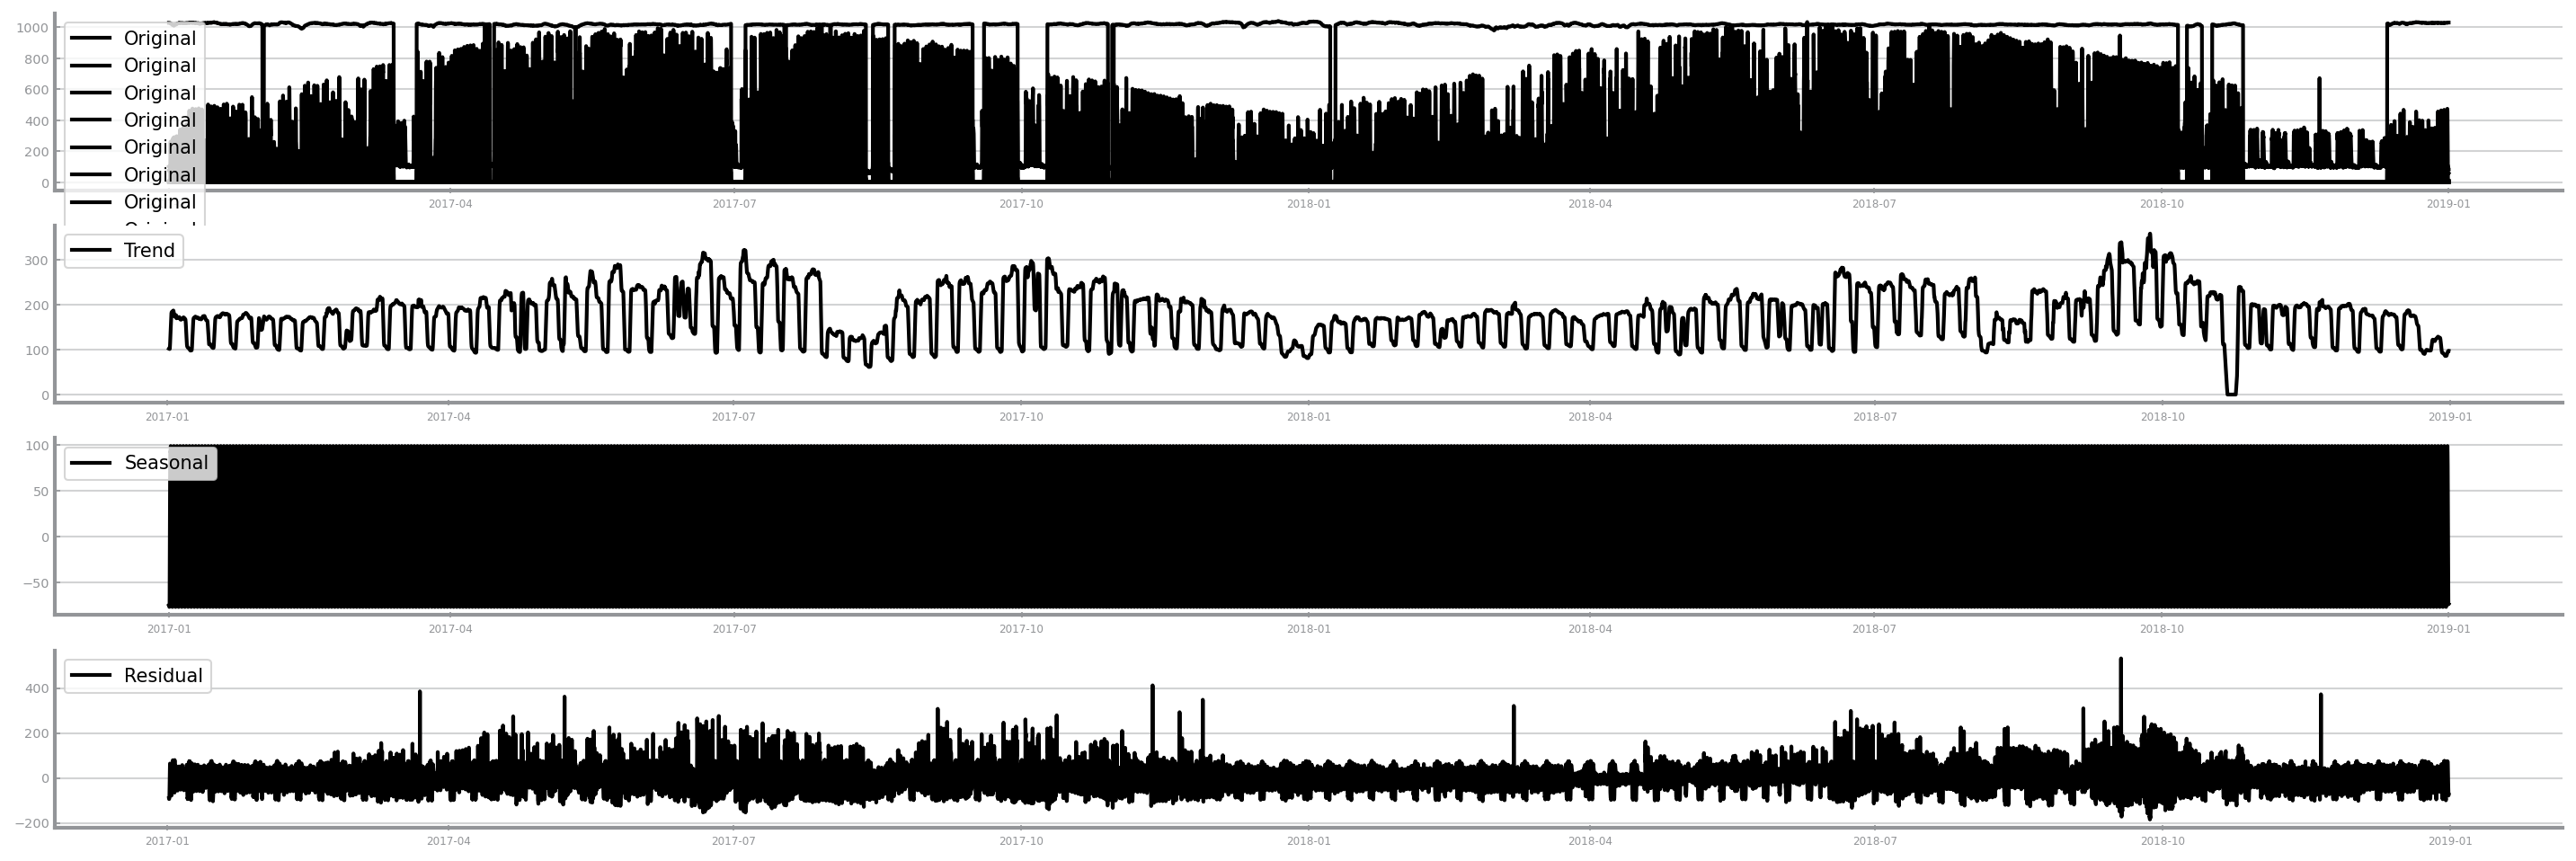

In [8]:
from ds_tools.profiling import plot_seasonal_decompose

# set periodicy to 24 since seasonal component is clearly with 24h in a day
plot_seasonal_decompose(df, column='Power_kW', period=24)

### Check Autocorrelation

Checking the correlation of the time series to itsef within a certain number of lags in the past.

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

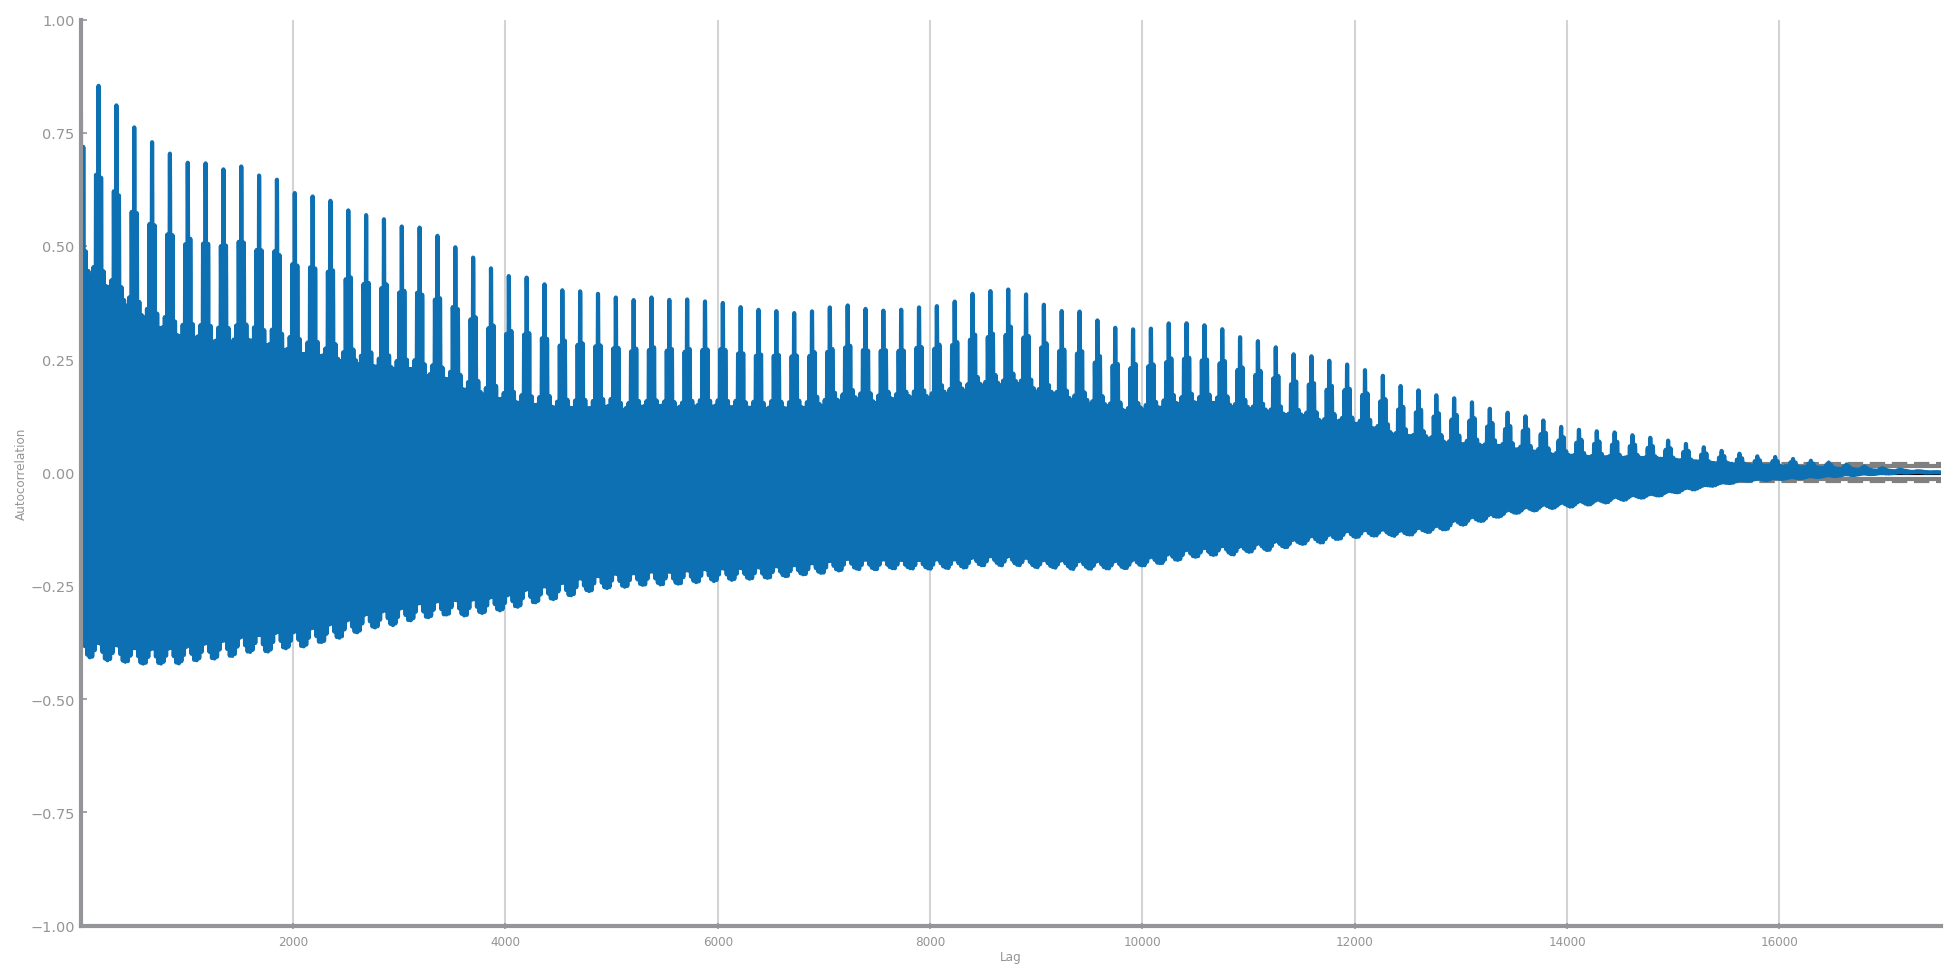

<Figure size 1500x1200 with 0 Axes>

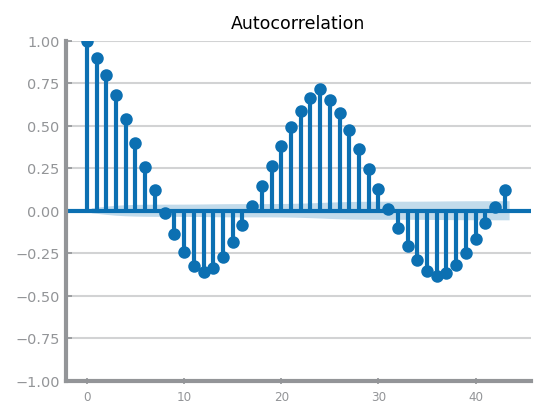

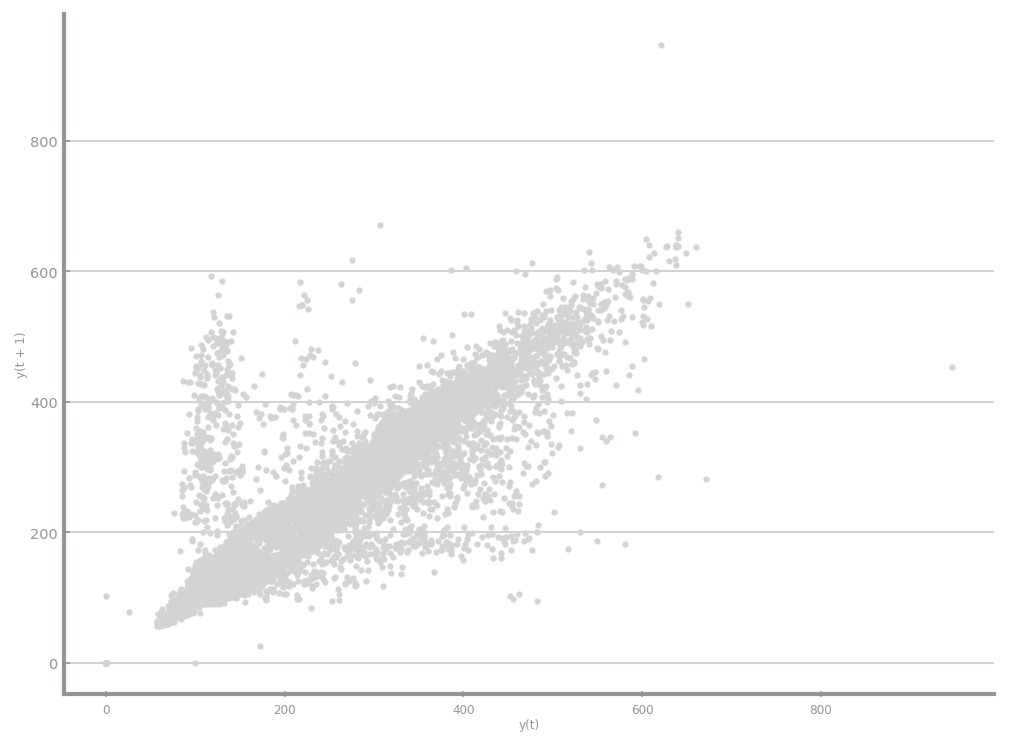

In [9]:
from pandas.plotting import autocorrelation_plot, lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pyplot import figure

figure(figsize=(16, 8))
autocorrelation_plot(df['Power_kW'])
figure(figsize=(10, 8))
plot_acf(df['Power_kW'])
figure(figsize=(8, 6))
lag_plot(df['Power_kW'])

## Scale Data

In [10]:
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame

data_bool = df['holiday']
data_numeric = df.drop(columns=['holiday'])
min_max_scaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data_numeric)
tmp_min_max = DataFrame(min_max_scaler.transform(data_numeric), index=df.index, columns=data_numeric.columns)

df_scaled = concat([tmp_min_max,  data_bool], axis=1)

df_scaled.head()

Power_kW    temp_C        HR  windSpeed_m/s  \
2017-01-01 00:00:00  0.106445  0.212791  0.756401       0.146757   
2017-01-01 01:00:00  0.104591  0.207178  0.760456       0.160336   
2017-01-01 02:00:00  0.104048  0.192232  0.777271       0.190567   
2017-01-01 03:00:00  0.107106  0.176002  0.815632       0.232290   
2017-01-01 04:00:00  0.103987  0.166355  0.824335       0.239606   

                     windGust_m/s  pres_mbar  solarRad_W/m2  rain_mm/h  \
2017-01-01 00:00:00      0.194394   0.989820       0.001125        0.0   
2017-01-01 01:00:00      0.166313   0.989820       0.001326        0.0   
2017-01-01 02:00:00      0.180345   0.988938       0.001529        0.0   
2017-01-01 03:00:00      0.215976   0.988858       0.001275        0.0   
2017-01-01 04:00:00      0.224613   0.988858       0.001518        0.0   

                     rain_day  holiday  
2017-01-01 00:00:00       0.0        1  
2017-01-01 01:00:00       0.0        1  
2017-01-01 02:00:00       0.0        1  
2017-01-01 03:00:00       0.0        1  
2017-01-01 04:00:00       0.0        1

## Clustering

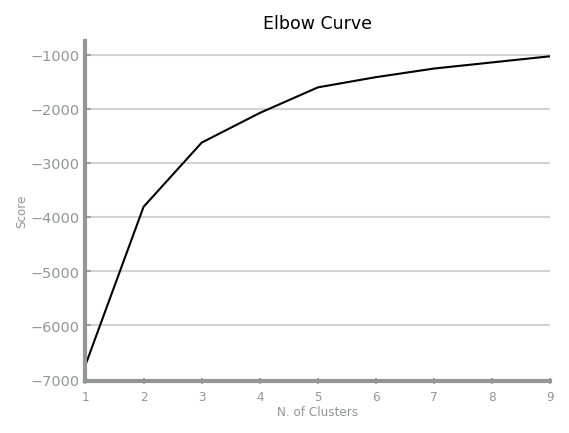

In [11]:
from sklearn.cluster import KMeans
from ds_tools.graphing.charts import plot_line

number_clusters = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in number_clusters]
score = [kmeans[i].fit(df_scaled).score(df_scaled) for i in range(len(kmeans))]

plot_line(number_clusters, score, title='Elbow Curve', x_label='N. of Clusters', y_label='Score')

Power_kW    temp_C        HR  windSpeed_m/s  \
2017-01-01 00:00:00  0.106445  0.212791  0.756401       0.146757   
2017-01-01 01:00:00  0.104591  0.207178  0.760456       0.160336   
2017-01-01 02:00:00  0.104048  0.192232  0.777271       0.190567   
2017-01-01 03:00:00  0.107106  0.176002  0.815632       0.232290   
2017-01-01 04:00:00  0.103987  0.166355  0.824335       0.239606   

                     windGust_m/s  pres_mbar  solarRad_W/m2  rain_mm/h  \
2017-01-01 00:00:00      0.194394   0.989820       0.001125        0.0   
2017-01-01 01:00:00      0.166313   0.989820       0.001326        0.0   
2017-01-01 02:00:00      0.180345   0.988938       0.001529        0.0   
2017-01-01 03:00:00      0.215976   0.988858       0.001275        0.0   
2017-01-01 04:00:00      0.224613   0.988858       0.001518        0.0   

                     rain_day  holiday  Clusters  
2017-01-01 00:00:00       0.0        1         1  
2017-01-01 01:00:00       0.0        1         1  
2017-01-01 02:00:00       0.0        1         1  
2017-01-01 03:00:00       0.0        1         1  
2017-01-01 04:00:00       0.0        1         1

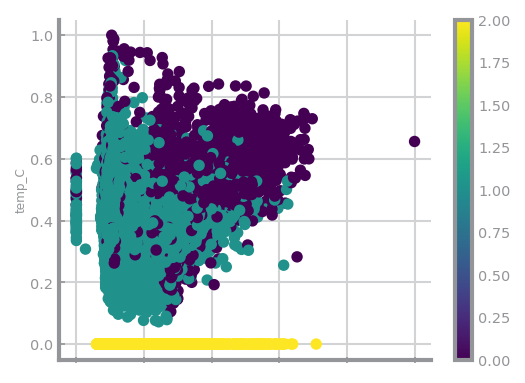

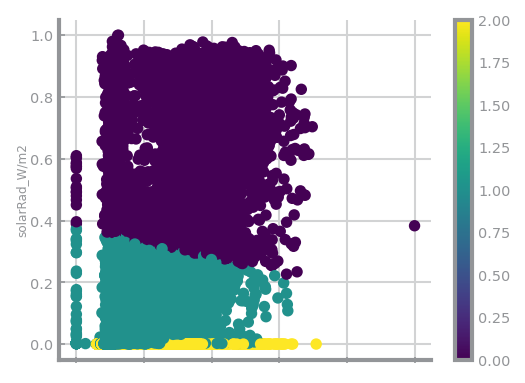

In [12]:
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=3).fit(df_scaled)

model = KMeans(n_clusters=3).fit(df)
df_scaled['Clusters'] = model.labels_

df_scaled.plot.scatter(x='Power_kW',y='temp_C', c=df_scaled['Clusters'], colormap='viridis')
df_scaled.plot.scatter(x='Power_kW',y='solarRad_W/m2', c=df_scaled['Clusters'], colormap='viridis')

df_scaled.head()

# Feature Engineering

## Feature Generation

#### Autocorrelation Features

In [13]:
df['Power_kW_-1_hour'] = df['Power_kW'].shift(1)
df['Power_kW_-1_day'] = df['Power_kW'].shift(24)
df = df.fillna(0)

#### Date Features

In [14]:
# add weekend information to dataframe
df['weekend'] = where(df.index.weekday > 4, 1, 0)

# extract date and time
df['hour'] = [date.hour for date in df.index]
df['day'] = [date.day for date in df.index]
df['month'] = [date.month for date in df.index]

## Feature Selection

<AxesSubplot:>

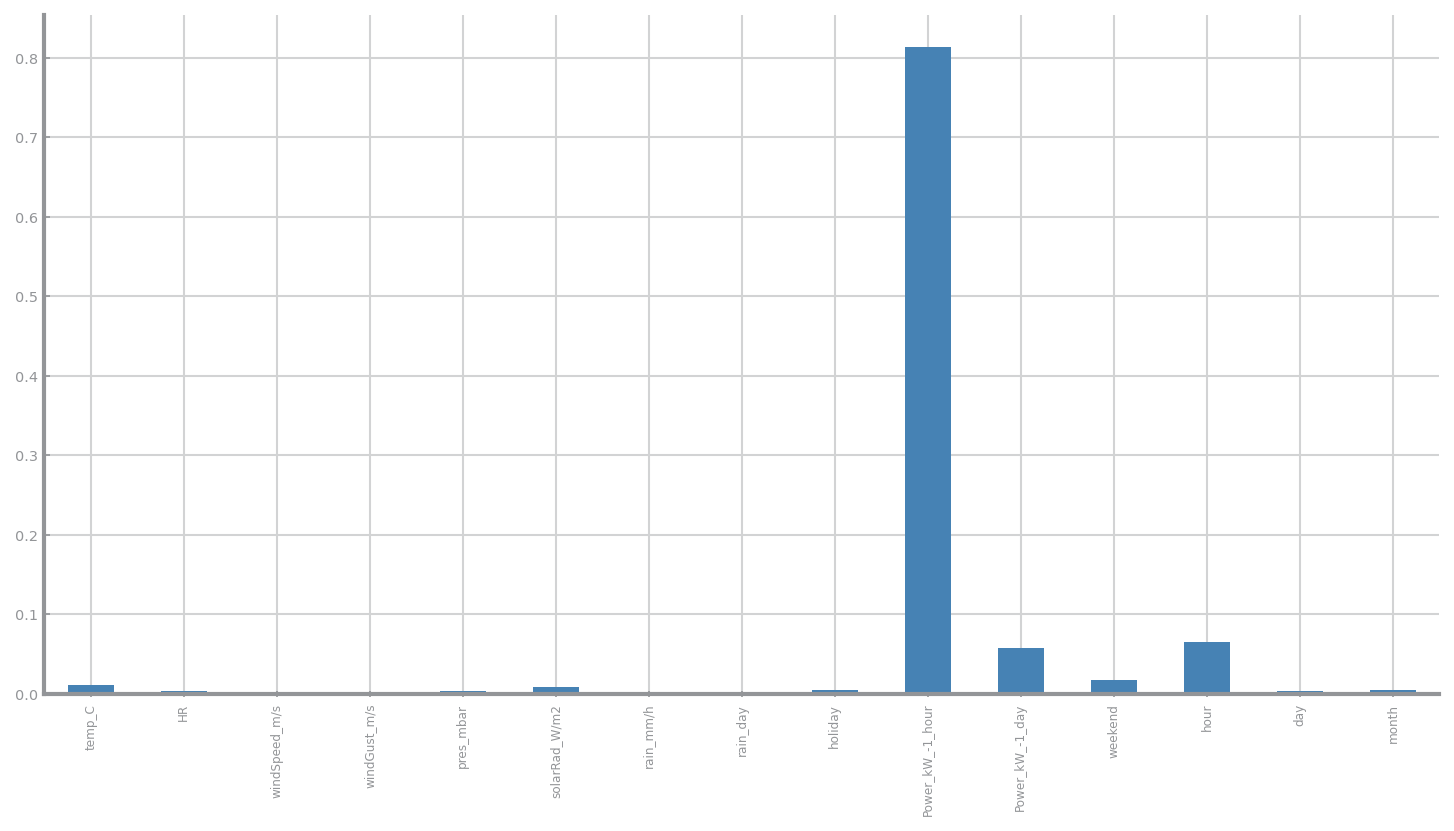

In [15]:
from pandas import Series
from ds_tools.utils import split_timeseries
from sklearn.tree import DecisionTreeRegressor

# define where to start
start = datetime(year=2017, month=1, day=1)
end = datetime(year=2018, month=12, day=31)

df_short_term = df[start:end]

train, test = split_timeseries(df_short_term, train_size=0.9)

# Identify target class Y
y_train = train[['Power_kW']]
y_test = test[['Power_kW']]

# Identify feature values X
x_train = train.drop('Power_kW', axis=1)[:]
x_test = test.drop('Power_kW', axis=1)[:]

clf = model = DecisionTreeRegressor()
clf.fit(x_train, y_train)

Series(clf.feature_importances_, index=df_short_term.columns[1:]).plot.bar(color='steelblue', figsize=(12, 6))

In [25]:
# define features manually based on results from clusterinig, correlation, autocorrelation and decisiontree classifing
features = ['temp_C', 'HR', 'solarRad_W/m2', 'holiday', 'Power_kW_-1_hour', 'Power_kW_-1_day', 'weekend', 'hour']


# Modeling

As we are supposed to predict many hours, days or months ahead and our dataset consists of many variables, we have need to design a multivariate multi-step time series forecasting model.

The data is split into training and testing data.
90% of the data is used dor training and 10% for testing and is also the lenght of the forecast.

## Short-term Forecast

Goal: Develop a model that predicts the next days consumption as good as possible.

In [26]:
# split into train and test
from ds_tools.utils import split_timeseries

# define where to start
start = datetime(year=2018, month=12, day=1)
end = datetime(year=2018, month=12, day=23)

df_short_term = df[start:end]

train, test = split_timeseries(df_short_term, train_size=0.9)

# Identify target class Y
y_train = train[['Power_kW']]
y_test = test[['Power_kW']]
# Identify feature values X
x_train = train[features]
x_test = test[features]

### Prophet Model

In [18]:
%%capture
#from ds_tools.time_series_models import prophet_auto_ml
#prediction_prophet = prophet_auto_ml(timestamp=train.index, prediction_variable=train.values, holidays=holidays, predict_period=PREDICT_PERIOD)

### SARIMAX Model

/Users/tobiassteggemann/energy-services-project-py/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/tobiassteggemann/energy-services-project-py/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


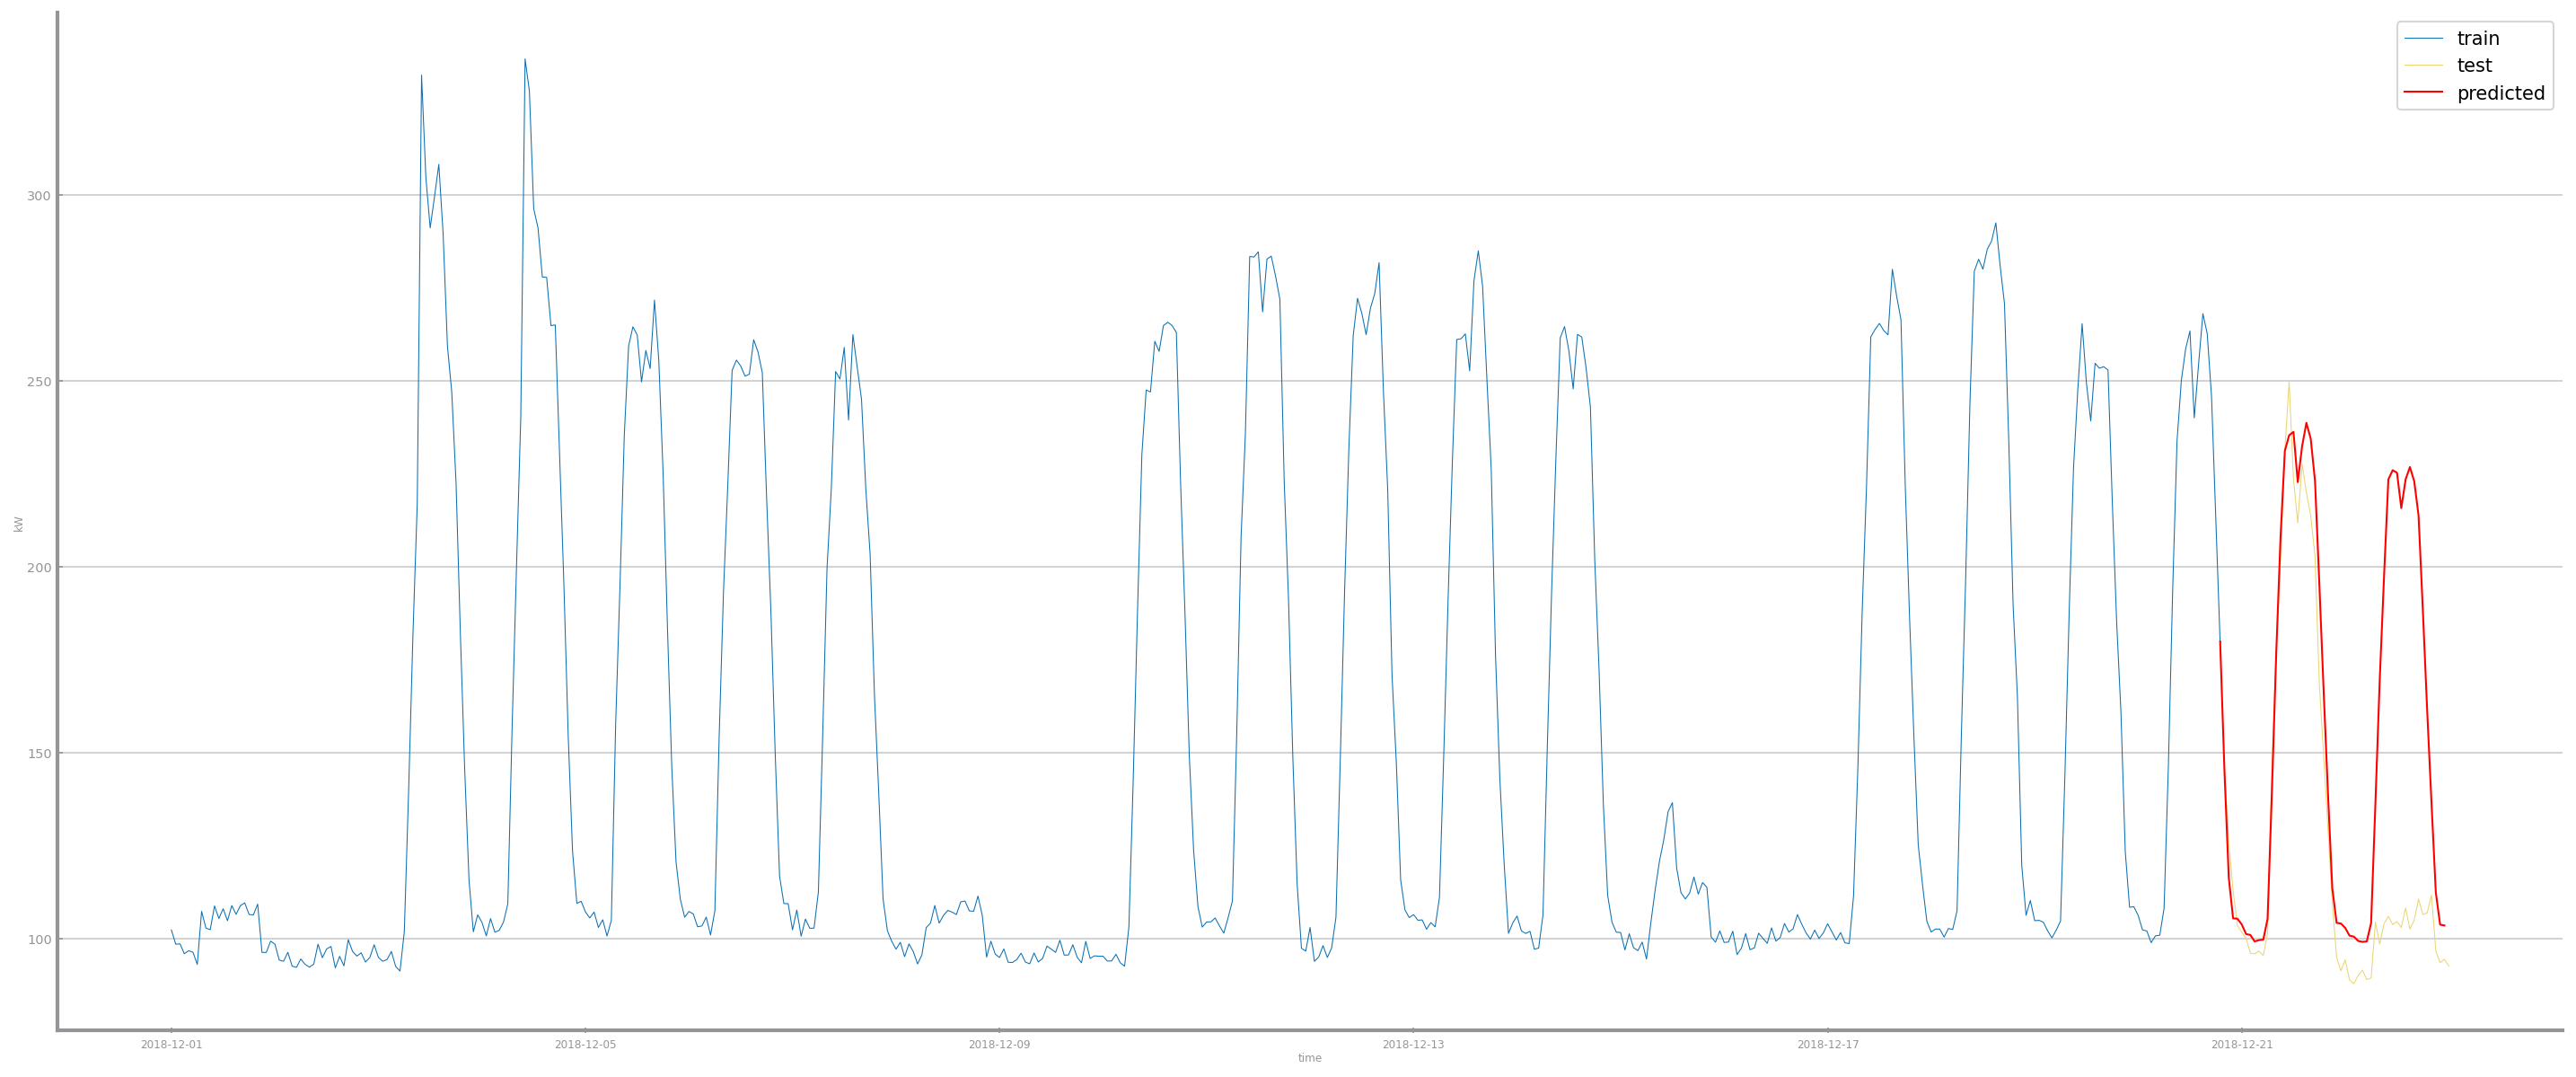

In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from ds_tools.time_series_evaluation import evaluate_forecasts
from ds_tools.graphing.charts import plot_forecasting
import matplotlib.pyplot as plt

model = SARIMAX(train['Power_kW'], order=(0,0,1), seasonal_order =(1, 1, 1, 24), freq='H')
result = model.fit(disp=False)
prediction_arima = result.predict(start=len(train)-1, end=len(df_short_term)-2)

plot_forecasting(train=train['Power_kW'], test=test['Power_kW'], pred=prediction_arima, x_label='time', y_label='kW')

### Autoregression Model

/Users/tobiassteggemann/energy-services-project-py/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/tobiassteggemann/energy-services-project-py/venv/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


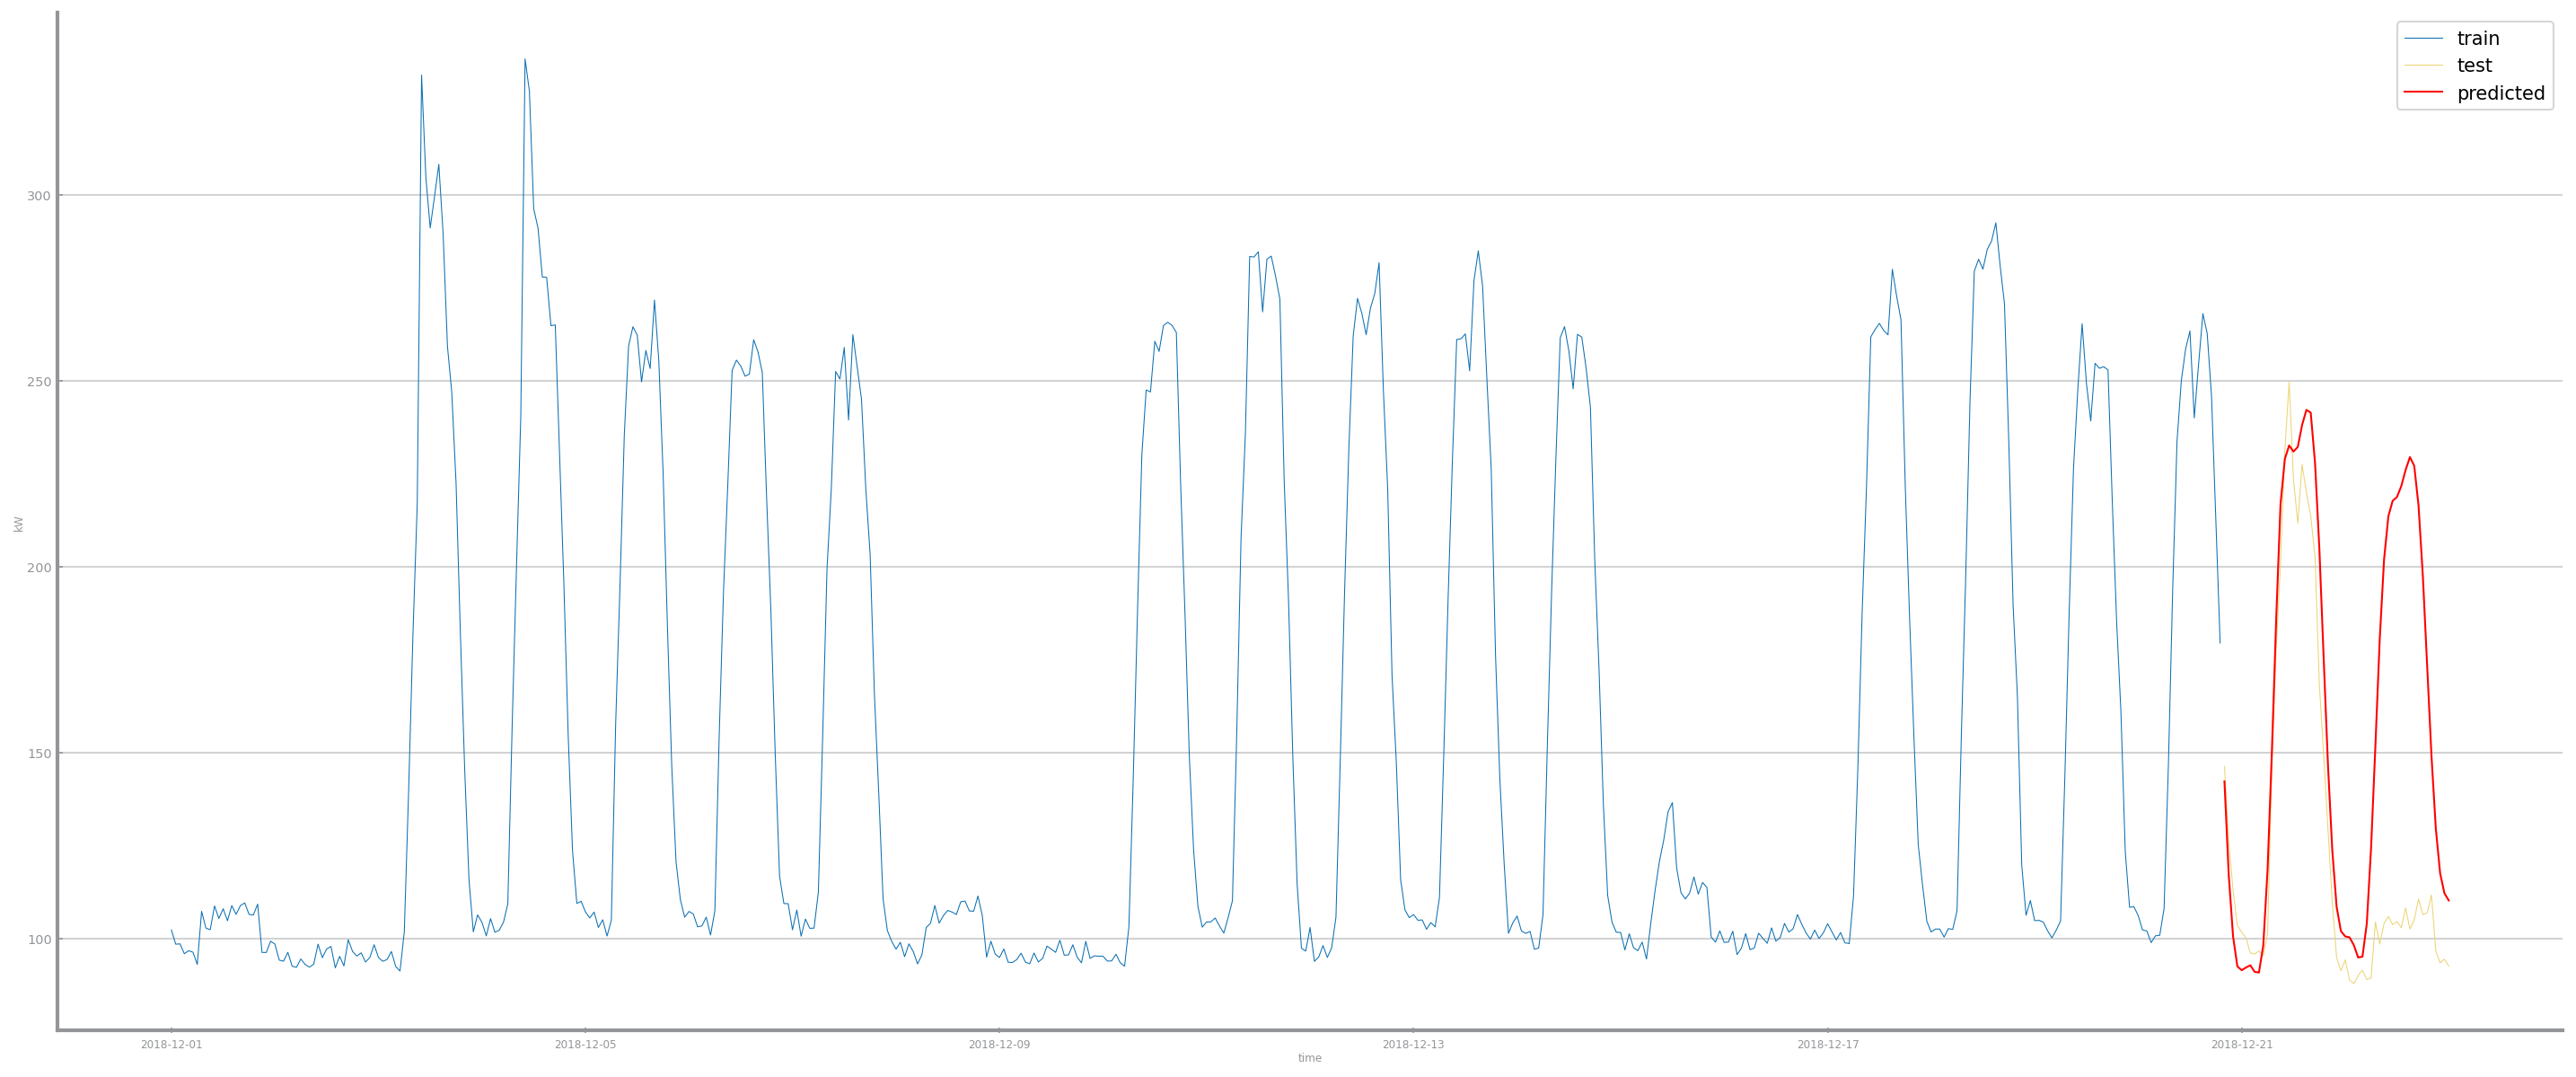

In [38]:
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(train['Power_kW'], lags=24).fit()
predictions_autoreg = model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
plot_forecasting(train=train['Power_kW'], test=test['Power_kW'], pred=predictions_autoreg, x_label='time', y_label='kW')

### Linear Regression

<Figure size 3600x1500 with 0 Axes>

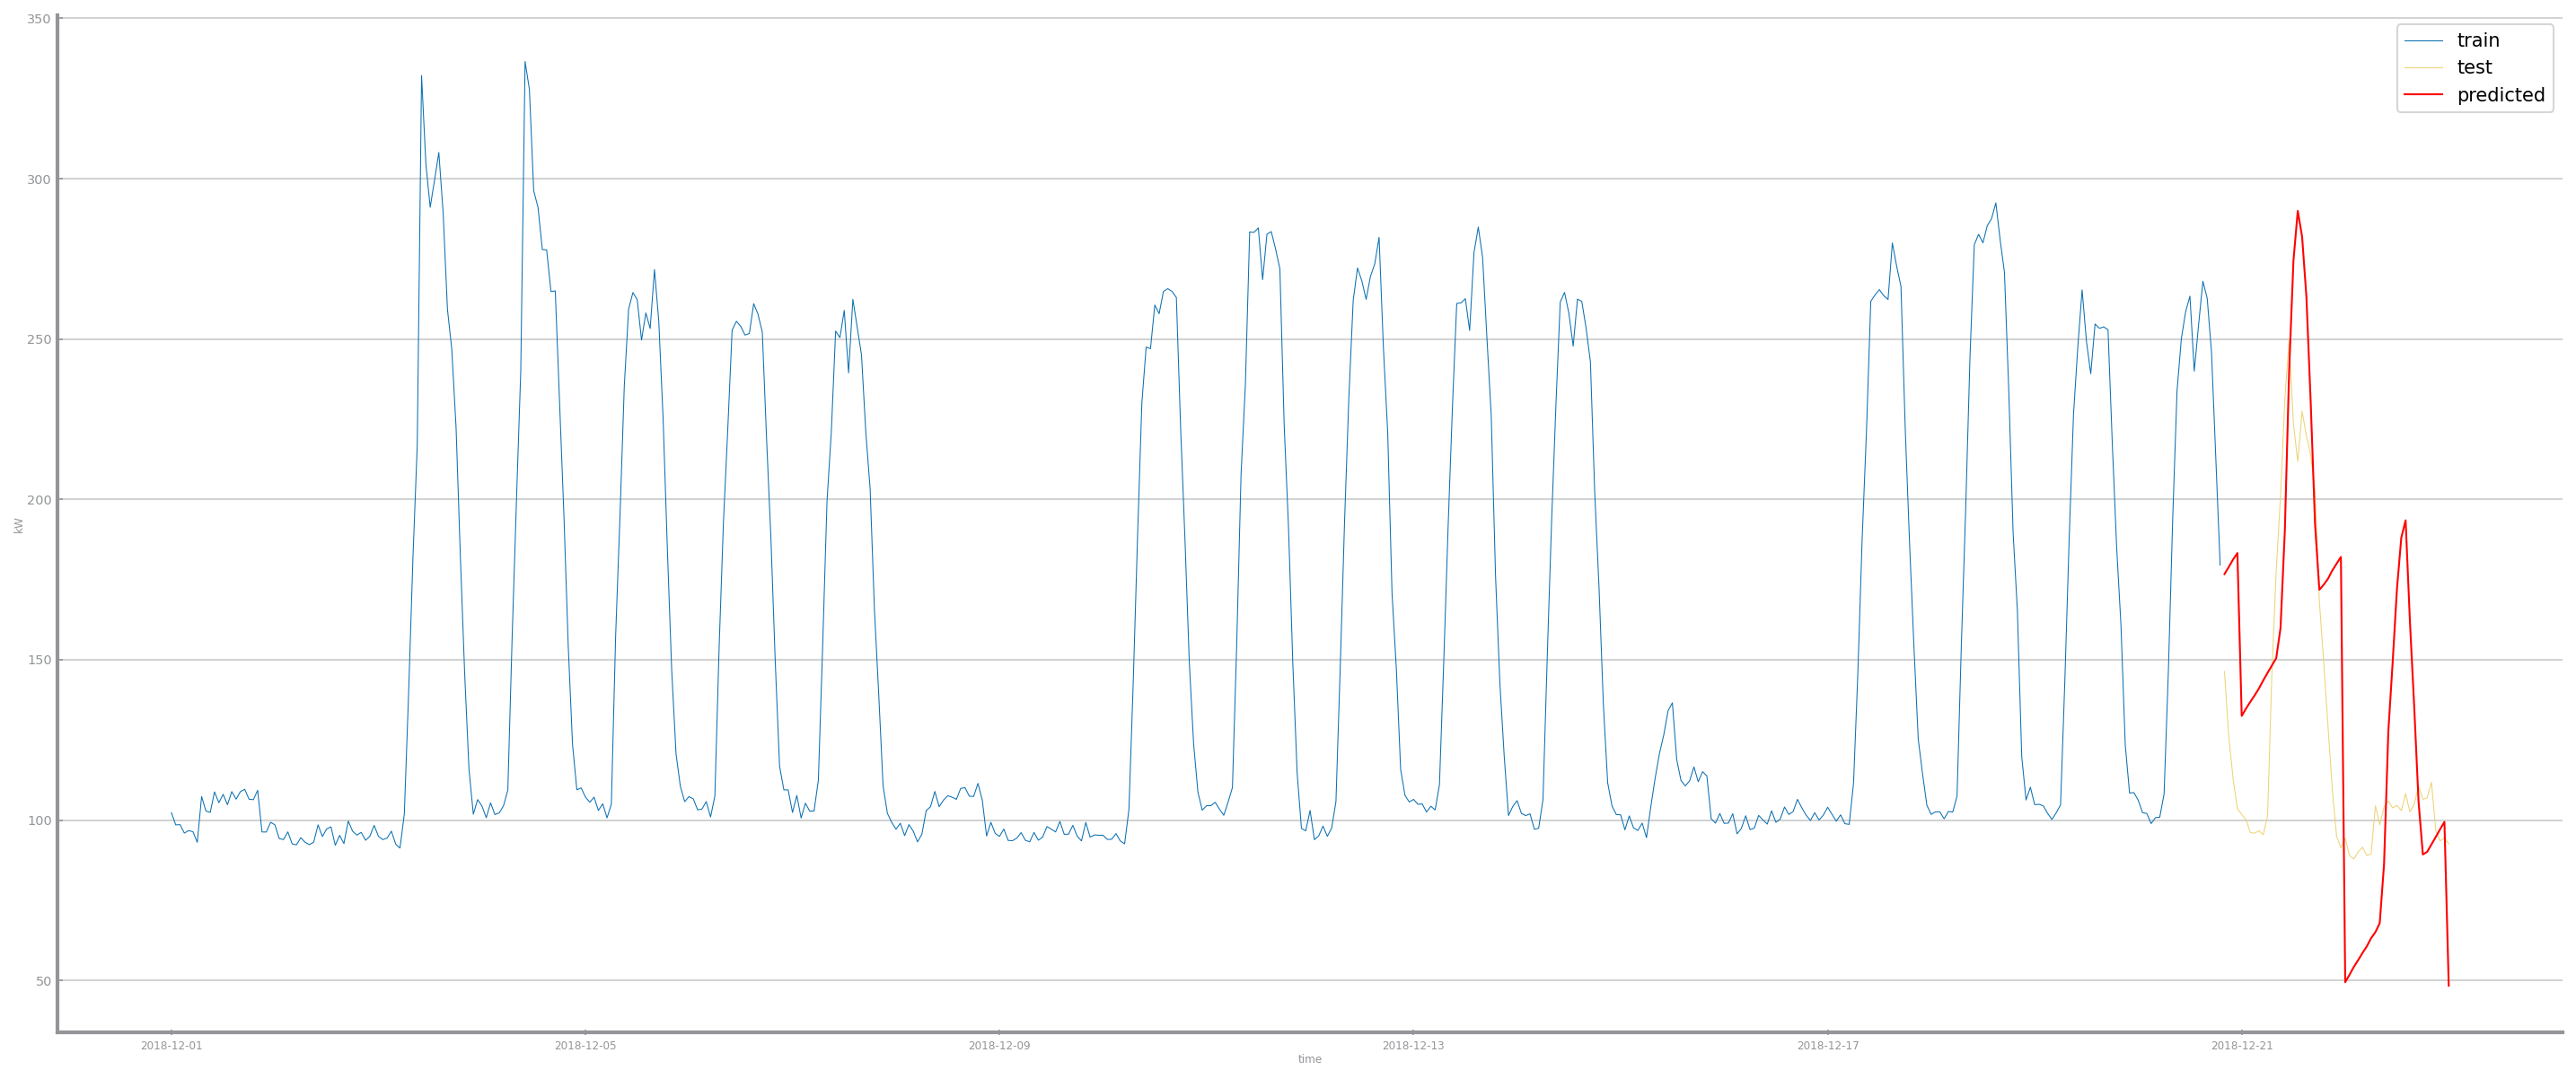

In [40]:
from sklearn import linear_model
from pandas import DataFrame

model = linear_model.LinearRegression()

# Train the model using the training sets
model.fit(x_train, y_train)

# Make predictions using the testing set
figure(figsize=(24, 10))
pred_linear_regression = DataFrame(model.predict(x_test))
pred_linear_regression.index = y_test.index

# Eval only next day
plot_forecasting(train=train['Power_kW'], test=test['Power_kW'], pred=pred_linear_regression, x_label='time', y_label='kW')

## Decision Tree Regressor

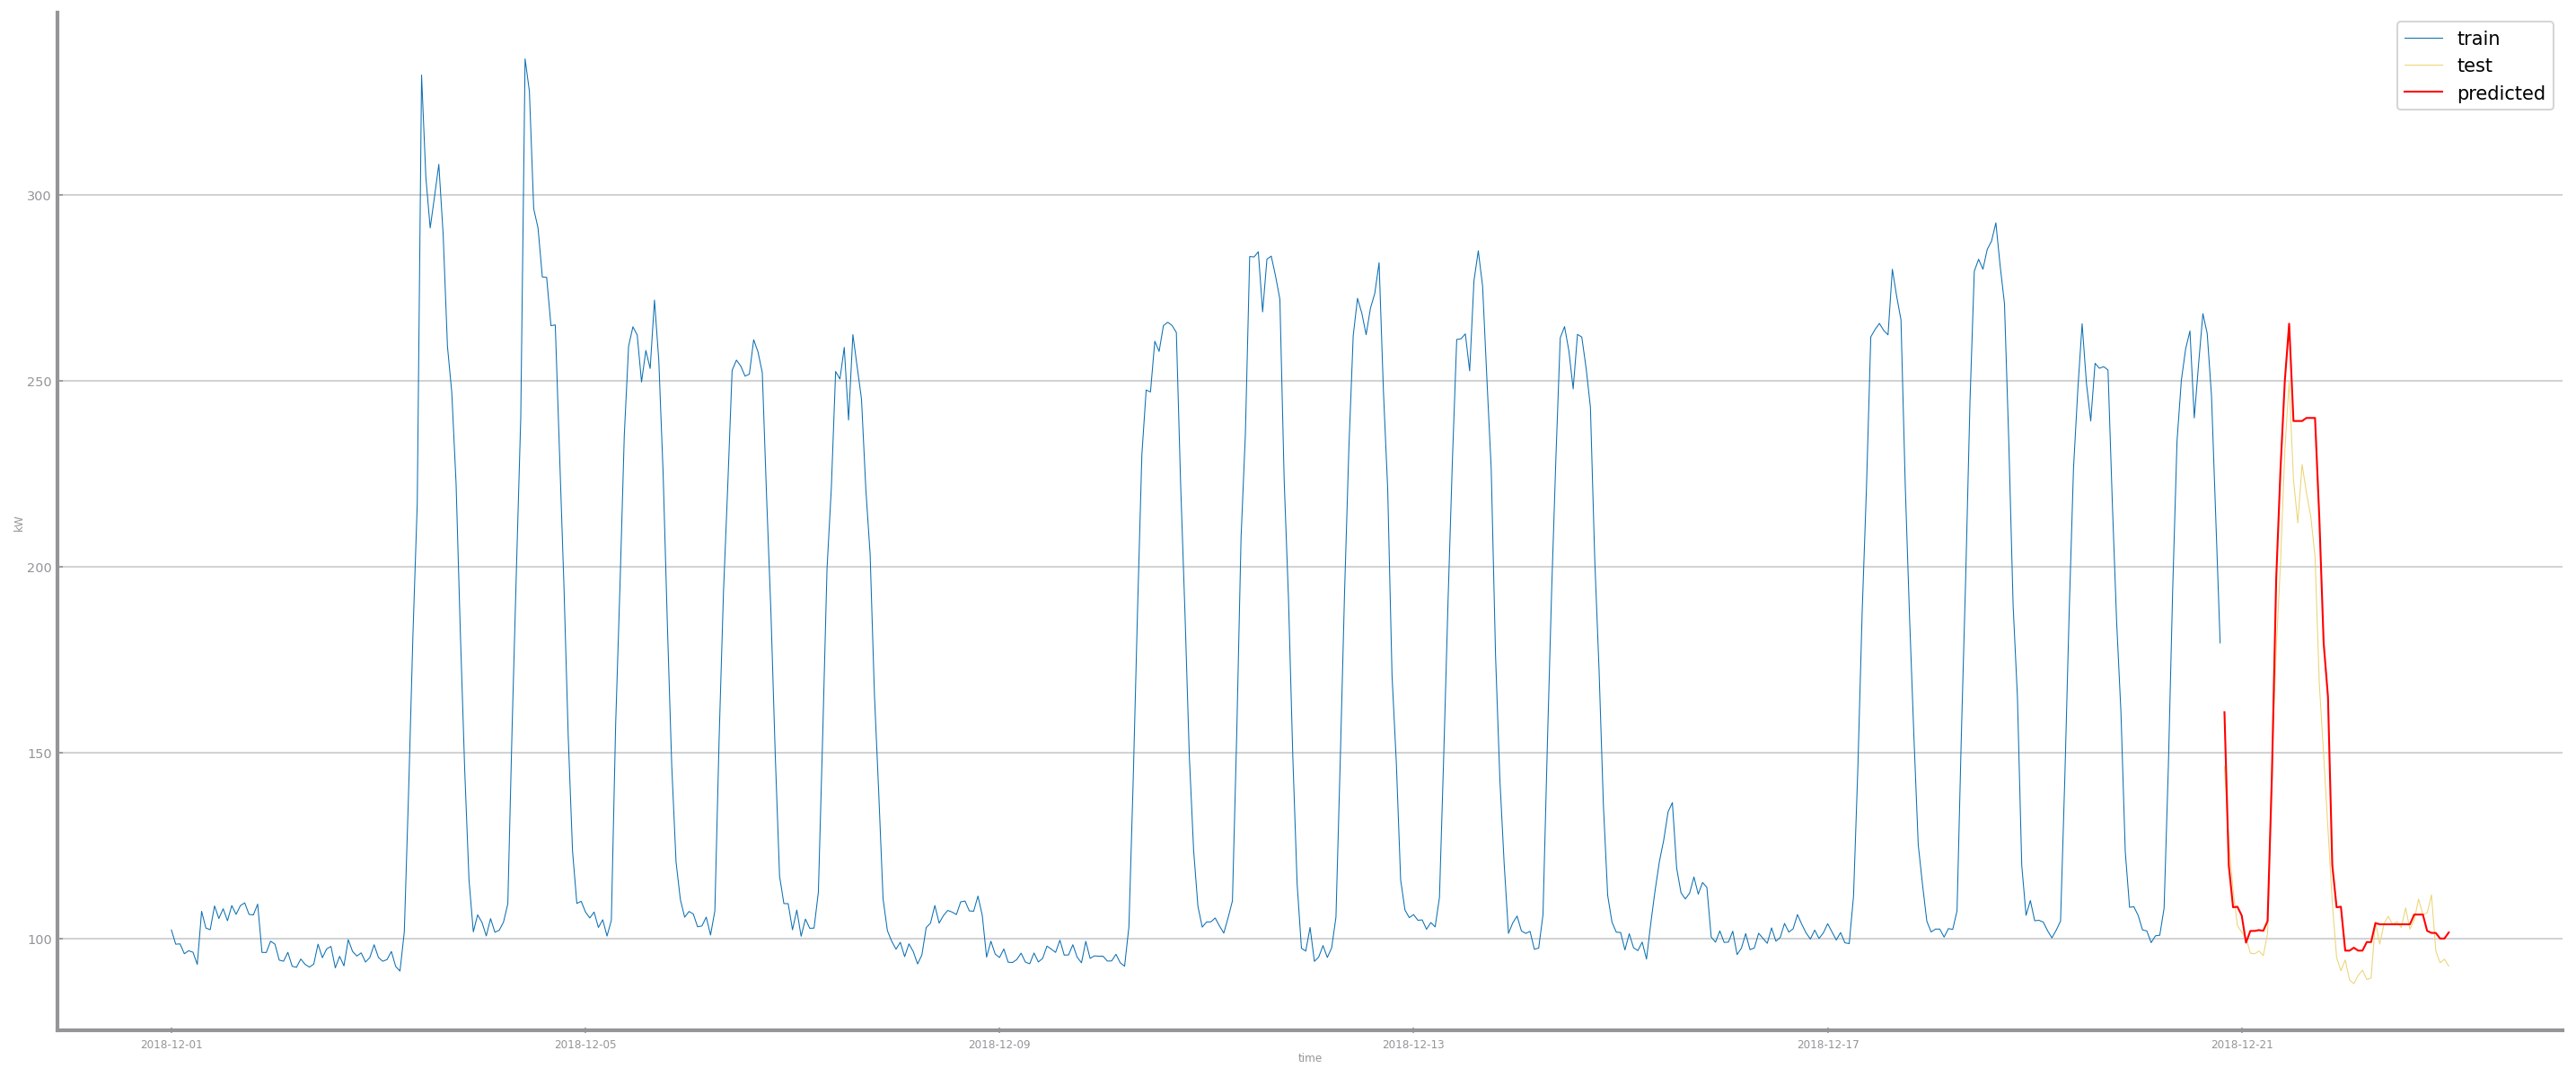

In [41]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(x_train, y_train)
prediction_decision_tree = DataFrame(model.predict(x_test))
prediction_decision_tree.index = y_test.index

plot_forecasting(train=train['Power_kW'], test=test['Power_kW'], pred=prediction_decision_tree, x_label='time', y_label='kW')

# Model Evaluation

Using MAPE (Mean absolute percentage error) to Evaluate Models

In [ ]:
figure()
plt.plot(predictions_autoreg)
plt.plot(prediction_arima)
plt.plot(test["Power_kW"])
figure()
plt.scatter(predictions_autoreg[:24], test["Power_kW"][:24])

print(evaluate_forecasts(actual=y_test[:24], predicted=y_pred[:24]))